In [1]:
import pandas as pd
import os
import numpy as np
from scipy.stats import mannwhitneyu
import seaborn as sns
from matplotlib import pyplot as plt
import re
from scipy.stats import mannwhitneyu
import warnings
warnings.filterwarnings('ignore') #supresses warnings for now
#warnings.filterwarnings(action='once') #shows warnings once
from statannotations.Annotator import Annotator


dataFilePath = os.path.join(os.getcwd(),'Data')

kicsSVdf = pd.read_csv(os.path.join(dataFilePath,'kics_structural_variations.txt'), sep = '\t', header = 0)
#kicsTEdf = pd.read_csv(os.path.join(dataFilePath,'kics_transposable_elements.txt'), sep = '\t', header = 0)
lfsSVdf = pd.read_csv(os.path.join(dataFilePath,'lfs_structural_variations.txt'), sep = '\t', header = 0)
#lfsTEdf = pd.read_csv(os.path.join(dataFilePath,'lfs_transposable_elements.txt'), sep = '\t', header = 0)
lfsClinicdf = pd.read_csv(os.path.join(dataFilePath,'lfs_clinical_main.tsv'), sep = '\t', header = 0)
kicsClinicdf = pd.read_csv(os.path.join(dataFilePath,'kics_clinical_edited.csv'), encoding='latin-1')

In [2]:
"""
SV clean up
"""
def maxGDAFFilter(colName: str, df: pd.DataFrame)->pd.DataFrame:
    temp = df[colName].str.contains(pat=',')
    Index = list(np.where(temp == True)[0])
    temp = df[colName].iloc[Index]
    tempIndex = temp.index 
    
    for i in tempIndex:
        tempList = temp[i].split(',')
        tempList = [float(a) for a in tempList]
        maxTemp = max(tempList)
        df[colName][i] = maxTemp

    df[colName] = df[colName].astype('float64')
    
    return df
    
kicsSVdf = maxGDAFFilter('GD_AF', kicsSVdf)
lfsSVdf = maxGDAFFilter('GD_AF', lfsSVdf)

listValSearch = ['291775', '298313', '315666', '320118', '18_1907']
# searched for kID of 63, 83, 156, 171, 219
# kID 120 141 and 232 do not have any matches...
#what would make this that much better is if it was a dict. Computationally less heavy?

for i in listValSearch: 
    kicsSVdf.drop(kicsSVdf[kicsSVdf['sample_id'].str.contains(i)==True].index, inplace = True)

In [3]:
"""
full filter and rare
"""

kicsSVdf = kicsSVdf.loc[(kicsSVdf['AnnotSV type'] == 'full') & (kicsSVdf['GD_AF'] < 0.01)]
lfsSVdf = lfsSVdf.loc[(lfsSVdf['AnnotSV type'] == 'full') & (lfsSVdf['GD_AF'] < 0.01)]

kicsSVdf['SV chrom'] = kicsSVdf['SV chrom'].astype(str)
lfsSVdf['SV chrom'] = lfsSVdf['SV chrom'].astype(str)

kicsSVdf['sample_id'] = kicsSVdf['sample_id'].astype(str)
lfsSVdf['sample_id'] = lfsSVdf['sample_id'].astype(str)

kicsSVdf['sample_id'] = kicsSVdf['sample_id'].str.replace(" ", "")
lfsSVdf['sample_id'] = lfsSVdf['sample_id'].str.replace(" ", "")

#kicsSVnum = kicsSVF['sample_id'].count()
#lfsSVnum = lfsSVF['sample_id'].count()


In [4]:
"""
Kics clinic df cleaning
"""
#listValSearch = ['291775', '298313', '315666', '320118', '18_1907']
listValSearch = ['63', '83', '156', '171', '219', '120', '141', '232']
# searched for kID of 63, 83, 156, 171, 219
# kID 120 141 and 232 do not have any matches...

kicsClinicdf['KiCS ID'] = kicsClinicdf['KiCS ID'].astype(str)
kicsClinicdf['KiCS ID'] = kicsClinicdf['KiCS ID'].str.replace(" ", "")

for i in listValSearch:
    kicsClinicdf.drop(kicsClinicdf[kicsClinicdf['KiCS ID']==i].index, inplace = True)

#these two lines are causing us to go from 140->90 ish samples    
kicsClinicdf.drop(kicsClinicdf.loc[kicsClinicdf['tissue_type']=='?'].index, inplace=True)
kicsClinicdf.drop(kicsClinicdf.loc[pd.isna(kicsClinicdf['lfs_cancer_type_diagnosis'])].index, inplace=True)


# # intial tissue types and diagnosis types
# kUniqueTissue = kicsClinicdf['tissue_type'].unique()
# kUniqueDiag = kicsClinicdf['lfs_cancer_type_diagnosis'].unique()

# print(kUniqueTissue)
# print(kUniqueDiag)

In [5]:
"""
lfs clinic df cleaning
"""
lfsClinicdf['sample'] = lfsClinicdf['sample'].astype(str)
lfsClinicdf['sample'] = lfsClinicdf['sample'].str.replace(" ", "")

for i in listValSearch:
    lfsClinicdf.drop(lfsClinicdf[lfsClinicdf['sample']==i].index, inplace = True)
    

#print(lfsClinicdf[lfsClinicdf['tissue_type']=='CNS']) #more than 1 patient
    
lfsClinicdf.drop(lfsClinicdf.loc[lfsClinicdf['tissue_type']=='?'].index, inplace=True)
lfsClinicdf.drop(lfsClinicdf.loc[pd.isna(lfsClinicdf['cancer_diagnosis'])].index, inplace=True)


#print(lfsClinicdf[lfsClinicdf['tissue_type']=='CNS']) #more than 1 patient

# lUniqueTissue = lfsClinicdf['tissue_type'].unique()
# lUniqueDiag = lfsClinicdf['cancer_diagnosis'].unique()

# print(lUniqueTissue)
# print(lUniqueDiag)

In [6]:
def BoxGraphMulti(df: pd.DataFrame, xCol, yCol, compCol, orderList):
    plt.rcParams["figure.figsize"] = [15, 10]
    ax = sns.boxplot(data=df, x=xCol, y=yCol, hue=compCol, medianprops={"linewidth": 4, 'color':'black'})
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha="right")

    
    lfs = df[df[compCol]=='lfs']
    kics = df[df[compCol]=='kics']
    
    excludeList = list(set(lfs[xCol]).symmetric_difference(set(kics[xCol])))

    #add statistical test here
    listPairing = []
    #pairings for multi correction
    for i in orderList:
        #excludeList = ['Unaffeceted', 'Sarcoma', 'Other', 'US', 'Thyroid', 'Ovaries']        
        #tissueDiff = list(set(df['tissue_type']).symmetric_difference(set(df['tissue_type'])))
        #diagDiff = list(set(df['cancer_diagnosis']).symmetric_difference(set(df['lfs_cancer_type_diagnosis'])))
        
        if i not in excludeList:
            p1 = (i, 'kics')
            p2 = (i, 'lfs')
            p = (p1,p2)
            listPairing.append(p)
        
    annot = Annotator(ax, listPairing, data=df, x=xCol, y=yCol, hue=compCol)
    annot.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose=2)
    annot.apply_and_annotate()

    plt.show()

In [7]:
def BarGraphNormalized(label1: str, label2:str, df: pd.DataFrame, col1: str, col2: str,
                        xTitle: str, yTitle: str, divisor1: float, divisor2: float,
                        labels: list):
    #'kics', 'lfs', invdf, 'kchrom', 'lchrom', 'Chromosomes','Frequency','Graph2-INV',kicsSVnum, lfsSVnum

    title = label1 + " " + label2
    count1 = df[col1].value_counts()
    count2 = df[col2].value_counts()
    
    x_axis = np.arange(len(labels))
        
    for i in labels:
        if (not(i in count1)):
            add = pd.Series([0], index=[i])
            count1 = count1.append(add)
        if (not(i in count2)):
            add = pd.Series([0], index=[i])
            count2 = count2.append(add)
            
    plt.bar(x_axis - 0.2, [count1[a]/divisor1 for a in labels], 0.4, label = label1)
    plt.bar(x_axis + 0.2, [count2[a]/divisor2 for a in labels], 0.4, label = label2)

    #plt.tick_params(labelrotation=45, labelright=True)
    #plt.setp(ha="right", rotation=45)
    
    plt.xticks(x_axis, labels, ha='right', rotation = 45)
    plt.xlabel(xTitle)
    plt.ylabel(yTitle)
    plt.title(title)
    plt.legend()
    plt.show()


In [9]:
"""
kics matching between SV and Clinical
"""

def kIdAbbv(clinicDf, svDf, clinicCol, svCol):
    
    clinicDf.drop(clinicDf[clinicDf[clinicCol]=='Not applicable'].index, inplace = True)
    
    svDf[svCol] = svDf[svCol].astype(str)
    clinicDf[clinicCol] = clinicDf[clinicCol].astype(str)
    svDf[svCol] =  svDf[svCol].str.replace(" ", "")
    clinicDf[clinicCol] = clinicDf[clinicCol].str.replace(" ", "")
    
    list1 = svDf[svCol].unique()
    list2 = clinicDf[clinicCol].unique()
    
    svDict = dict()
    clinicDict = dict()
    
    for i in range (len(list1)):
        tempList = re.findall('\d{3,}', list1[i])

        #if empty, take the second one
        if not tempList:
            tempList = re.findall('\d+', list1[i])
            svDict[list1[i]] = tempList[1]

        #if not empty 
        else:
            svDict[list1[i]] = tempList[0]


    for i in range (len(list2)):    
        tempList = re.findall('\d{3,}', list2[i])
    
        #if empty, take the second one
        if not tempList:
            tempList = re.findall('\d+', list2[i])
            clinicDict[list2[i]] = tempList[1]

        #if not empty 
        else:
            clinicDict[list2[i]] = tempList[0]
    

    clinicDf['abbv_id'] = clinicDf[clinicCol].map(clinicDict)
    svDf['abbv_id'] = svDf[svCol].map(svDict)
    
    print(len(svDf[svCol].unique()))
#     print(svDf[svCol].unique())
    
    df = pd.merge(svDf[[svCol,'SV type','abbv_id']],                   
                     clinicDf[[clinicCol, 'tumour_class','tissue_type',
                               'lfs_cancer_type_diagnosis', 'abbv_id','diagnosis_age (days)']],
                     left_on = 'abbv_id', 
                     right_on = 'abbv_id', 
                     how='inner')
    return df

In [16]:
bigKDf = kIdAbbv(kicsClinicdf, kicsSVdf, 'CCP germline', 'sample_id')
bigKDf=bigKDf.rename(columns={'diagnosis_age (days)': 'ageofonset'})
print(len(bigKDf['abbv_id'].unique()))
# print(bigKDf['sample_id'].unique())
# print(len(kicsSVdf['sample_id'].unique()))
# print(len(kicsClinicdf['CCP germline'].unique()))
#prints out how many we had before the id matching and how many we have left after the id matching

191
93


In [17]:
print(bigKDf)

      sample_id SV type abbv_id CCP germline       tumour_class tissue_type  \
0        313703     DEL  313703       313703         CNS TUMORS         CNS   
1        313703     DEL  313703       313703         CNS TUMORS         CNS   
2        313703     DUP  313703       313703         CNS TUMORS         CNS   
3        313703     DEL  313703       313703         CNS TUMORS         CNS   
4        313703     DEL  313703       313703         CNS TUMORS         CNS   
...         ...     ...     ...          ...                ...         ...   
16734    292600     DEL  292600       292600  LEUKEMIA/LYMPHOMA       Blood   
16735    292600     DEL  292600       292600  LEUKEMIA/LYMPHOMA       Blood   
16736    292600     INV  292600       292600  LEUKEMIA/LYMPHOMA       Blood   
16737    292600     DEL  292600       292600  LEUKEMIA/LYMPHOMA       Blood   
16738    292600     DEL  292600       292600  LEUKEMIA/LYMPHOMA       Blood   

      lfs_cancer_type_diagnosis ageofonset  
0     

In [18]:
"""Filter the ? and the nan"""
#print(bigKDf['tissue_type'].unique())
bigKDf.drop(bigKDf.loc[bigKDf['tissue_type']=='?'].index, inplace=True)

#bigKDfDiag.drop(bigKDf.loc[pd.isna(bigKDf['lfs_cancer_type_diagnosis'])].index, inplace=True)
print(len(bigKDf['abbv_id'].unique()))
#print(kicsClinicdf['tissue_type'].value_counts())

93


In [19]:
lfsSVdf['sample_id'] = lfsSVdf['sample_id'].astype(str)
lfsClinicdf['sample'] = lfsClinicdf['sample'].astype(str)

In [20]:
print(len(lfsSVdf['sample_id'].unique())) #only 65 to begin with D:
print(lfsSVdf['sample_id'].unique())

print(len(lfsClinicdf['sample'].unique()))

65
['4257' 'SJACT008_G' '808' '2085' '1087' '1092' '3805' '3136A' '4033'
 '2447' '353' '3806' '4854' '1478' '2262' '4028' '2957' '3688' '93' '1357'
 '2565' '4329' '4535_S1' '3298A' '2349' '2446' '3473' '5567' '3273' '3885'
 '3432' '1843' '3763' '3503' 'PD13489b' '2463' '2760A' '3643' 'SJACT001_G'
 '4227' '5537' '3367' 'SJACT002_G' '2815' '5536' '3634' '1476'
 'SJACT005_G' '3425' '3365' '2413' 'SJACT007_G' '3356' '3361' '3687_2'
 '3332' '94' '1355' '2784' '2465' '3319' 'PD7195b' '3334' '352' '2765']
460


In [21]:
"""
Can directly map the two
Apply on Filtered Prelim Graphs
"""

bigLDf = pd.merge(lfsSVdf[['sample_id','SV chrom','GD_AF', 'SV type']],
                 lfsClinicdf[['sample','tissue_type','cancer_diagnosis','ageofonset']],
                 left_on = 'sample_id',
                 right_on = 'sample',
                 how='inner')

In [22]:
"""
Difference between the unique tissues and unique diagnosis in kics vs lfs
"""

tissueDiff = list(set(bigLDf['tissue_type']).symmetric_difference(set(bigKDf['tissue_type'])))
diagDiff = list(set(bigLDf['cancer_diagnosis']).symmetric_difference(set(bigKDf['lfs_cancer_type_diagnosis'])))

print(tissueDiff)
print(diagDiff)

['Thyroid', 'Ovaries', 'Unaffected', 'Other']
['PNET', 'B-ALL', 'Thyroid', 'Ovaries', 'Unaffected', 'US', 'Undifferentiated sarcoma', 'T-LL', 'CPC', 'CSA', 'ALL', 'MFS', 'AA', 'LMS', 'MFH', 'Other', 'AMKL', 'T-NHL', 'Meningioma', 'AML', 'MPAL', 'High Grade Sarcoma', 'AL']


In [23]:
"""
Drop the rows that are in the diff
"""

####YOU DROPPED TOO MANY, Don't drop any
#bigLDf.drop(bigLDf[bigLDf['tissue_type'].isin(tissueDiff)].index, inplace = True)
#bigKDf.drop(bigKDf[bigKDf['tissue_type'].isin(tissueDiff)].index, inplace = True)

#bigLDf.drop(bigLDf[bigLDf['cancer_diagnosis'].isin(diagDiff)].index, inplace = True)
#bigKDf.drop(bigKDf[bigKDf['lfs_cancer_type_diagnosis'].isin(diagDiff)].index, inplace = True)

kicsTissue = pd.DataFrame(data = {'tissue_type':bigKDf['tissue_type'], 'id':bigKDf['sample_id']})
kicsT = kicsTissue

lfsTissue = pd.DataFrame(data = {'tissue_type':bigLDf['tissue_type'], 'id':bigLDf['sample']})
lfsT = lfsTissue

groupedTissue = pd.DataFrame(data={'ktissue':kicsTissue['tissue_type'], 'ltissue':lfsTissue['tissue_type']})

lfsDiag = pd.DataFrame(data = {'diag':bigLDf['cancer_diagnosis'], 'id':bigLDf['sample']})
# lfsD = lfsDiag
kicsDiag = pd.DataFrame(data = {'diag':bigKDf['lfs_cancer_type_diagnosis'], 'id':bigKDf['sample_id']})
kicsD = kicsDiag

groupedDiag = pd.DataFrame(data={'kdiag':kicsDiag['diag'],'ldiag': lfsDiag['diag']})

kicsTidList = kicsDiag['id'].unique()
lfsTidList = lfsDiag['id'].unique()
kicsDiagList = list(kicsDiag['diag'].unique())
lfsDiagList = list(lfsDiag['diag'].unique())

kicsIdList = kicsTissue['id'].unique()
kicsTissueList = list(kicsTissue['tissue_type'].unique())
lfsTissueList = list(lfsTissue['tissue_type'].unique())
lfsIdList = lfsTissue['id'].unique()

#print(type(kicsTissueList))

uniqueTissue = list(set(kicsTissueList+lfsTissueList))
uniqueDiag = list(set(kicsDiagList+lfsDiagList))

print(uniqueTissue)
print(uniqueDiag)
#print(kicsTissue['tissue_type'].unique())
#print(lfsTissue['tissue_type'].unique())


['Blood', 'Adrenal', 'Soft Tissue', 'US', 'Thyroid', 'Ovaries', 'Unaffected', 'Breast', 'Other', 'CNS', 'Bone', 'Colon']
['Glioma', 'Unaffected', 'Thyroid', 'Ovaries', 'US', 'Undifferentiated sarcoma', 'CPC', 'AA', 'ACC', 'AMKL', 'Meningioma', 'AML', 'High Grade Sarcoma', 'Colon', 'AL', 'ALL', 'B-ALL', 'T-LL', 'CSA', 'MFS', 'RMS', 'MFH', 'Breast', 'Other', 'T-NHL', 'OS', 'PNET', 'MPAL', 'LMS']


# Diagnosis Type

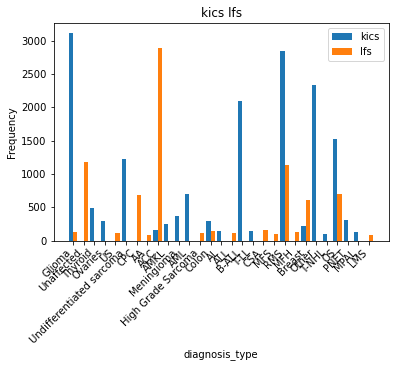

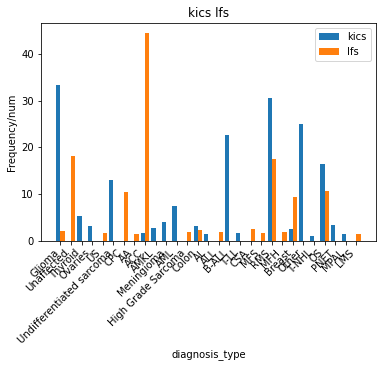

In [24]:
BarGraphNormalized('kics', 'lfs', groupedDiag, 'kdiag', 'ldiag', 'diagnosis_type', 'Frequency', 1.0,1.0, uniqueDiag)
    
BarGraphNormalized('kics', 'lfs', groupedDiag, 'kdiag', 'ldiag', 'diagnosis_type','Frequency/num',
                   len(kicsTidList), len(lfsTidList), uniqueDiag)

# Tissue Type

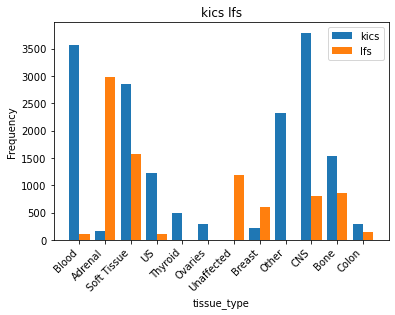

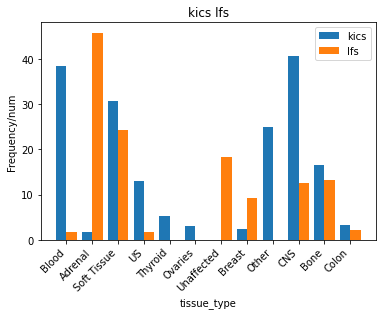

In [25]:
BarGraphNormalized('kics', 'lfs', groupedTissue, 'ktissue', 'ltissue', 'tissue_type','Frequency',
                   1.0,1.0, uniqueTissue)

BarGraphNormalized('kics', 'lfs', groupedTissue, 'ktissue', 'ltissue', 'tissue_type', 'Frequency/num',
                  len(kicsIdList), len(lfsIdList), uniqueTissue)

In [26]:
bigKDf.rename(columns = {'lfs_cancer_type_diagnosis':'cancer_diagnosis'}, inplace = True)

kDel = bigKDf.loc[bigKDf['SV type'] == 'DEL']
kDup = bigKDf.loc[bigKDf['SV type'] == 'DUP']
kInv = bigKDf.loc[bigKDf['SV type'] == 'INV']

lDel = bigLDf.loc[bigLDf['SV type'] == 'DEL']
lDup = bigLDf.loc[bigLDf['SV type'] == 'DUP']
lInv = bigLDf.loc[bigLDf['SV type'] == 'INV']

print(kDel.head(30))
print(lDel.head(30))

   sample_id SV type abbv_id CCP germline tumour_class tissue_type  \
0     313703     DEL  313703       313703   CNS TUMORS         CNS   
1     313703     DEL  313703       313703   CNS TUMORS         CNS   
3     313703     DEL  313703       313703   CNS TUMORS         CNS   
4     313703     DEL  313703       313703   CNS TUMORS         CNS   
5     313703     DEL  313703       313703   CNS TUMORS         CNS   
6     313703     DEL  313703       313703   CNS TUMORS         CNS   
7     313703     DEL  313703       313703   CNS TUMORS         CNS   
8     313703     DEL  313703       313703   CNS TUMORS         CNS   
9     313703     DEL  313703       313703   CNS TUMORS         CNS   
10    313703     DEL  313703       313703   CNS TUMORS         CNS   
11    313703     DEL  313703       313703   CNS TUMORS         CNS   
12    313703     DEL  313703       313703   CNS TUMORS         CNS   
13    313703     DEL  313703       313703   CNS TUMORS         CNS   
14    313703     DEL

In [27]:
def graphSVTissue(kdf, ldf, uniqueList, isTissue):
    if isTissue:
        var = 'tissue_type'

    else:
        var = 'cancer_diagnosis'
    
    kdf = kdf.drop(['sample_id', 'SV type','ageofonset'], axis=1)
    kdf = kdf.groupby(['abbv_id']).value_counts()
    kdf = kdf.to_frame().reset_index()

    kdf.rename(columns = {0:'freq'}, inplace = True)
    kdf = pd.melt(kdf, id_vars=[var], value_vars=['freq'])
    kdf['dataset'] = 'kics'

    ldf = ldf.drop(['SV chrom', 'GD_AF',
                        'SV type','ageofonset'], axis=1)
    ldf = ldf.groupby(['sample_id']).value_counts()
    ldf = ldf.to_frame().reset_index()
    ldf.rename(columns = {0:'freq'}, inplace = True)

    ldf = pd.melt(ldf, id_vars=[var], value_vars=['freq'])
    ldf['dataset'] = 'lfs'

    mergedDf = pd.concat([ldf, kdf])
    #print(mergedDf.head(50))
    
    BoxGraphMulti(mergedDf, var, 'value', 'dataset', uniqueList) 

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Glioma_lfs vs. Glioma_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:5.834e-01 U_stat=5.500e+00
Colon_lfs vs. Colon_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=1.000e+00
Breast_lfs vs. Breast_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:8.571e-01 U_stat=6.000e+00
OS_lfs vs. OS_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:7.895e-01 U_stat=2.000e+01
RMS_lfs vs. RMS_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:1.225e-02 U_stat=2.050e+01
ACC_lfs vs. ACC_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:5.281e-01 U_stat=6.000e+00


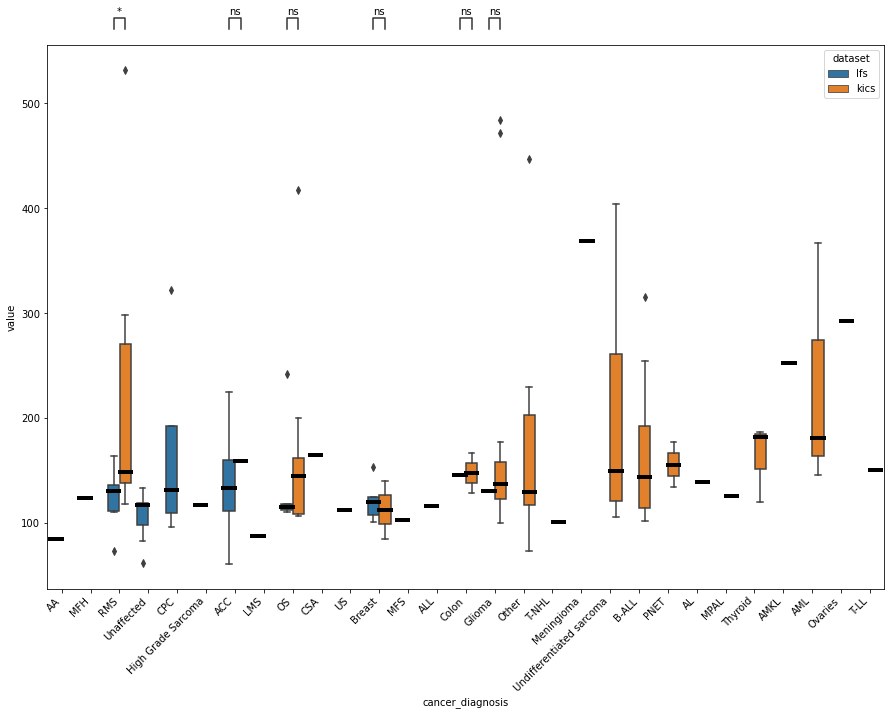

In [28]:
kicsTissue = bigKDf.drop(['CCP germline', 'tumour_class', 'cancer_diagnosis'], axis=1)
kicsDiag = bigKDf.drop(['CCP germline', 'tumour_class', 'tissue_type'], axis=1)

lfsTissue = bigLDf.drop(['cancer_diagnosis', 'sample'],axis=1)
lfsDiag = bigLDf.drop(['tissue_type', 'sample'],axis=1)

graphSVTissue(kicsDiag, lfsDiag, uniqueDiag, False)

#print(lfsTissue)
#graphSVTissue(bigKdf, bigLdf, uniqueTissue,)

## DEL

['Blood', 'Adrenal', 'Soft Tissue', 'US', 'Thyroid', 'Ovaries', 'Unaffected', 'Breast', 'Other', 'CNS', 'Bone', 'Colon']
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Colon_lfs vs. Colon_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=1.000e+00
Soft Tissue_lfs vs. Soft Tissue_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:4.412e-03 U_stat=2.850e+01
Adrenal_lfs vs. Adrenal_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:5.464e-01 U_stat=6.500e+00
Blood_lfs vs. Blood_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:4.305e-01 U_stat=5.000e+00
US_lfs vs. US_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:8.571e-01 U_stat=2.000e+00
Breast_lfs vs. Breast_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:8.571e-01 U_stat=6.000e+00
CNS_lfs vs. CNS_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:5.362e-01 U_stat=4.250e+01
Bone_lfs vs

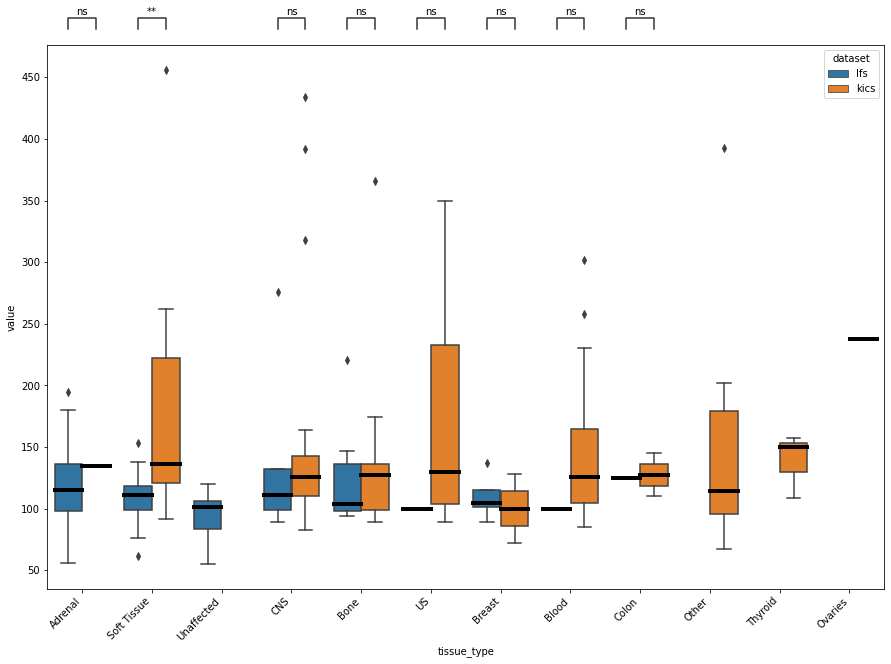

In [29]:
#print(kDel['tissue_type'].unique())
#print(lDel['tissue_type'].unique())
print(uniqueTissue)

graphSVTissue(kDel, lDel, uniqueTissue, True)

# for i in uniqueLabels:
#     print(i)
#     dog = normKdf.loc[normKdf['chrom'] == i]
#     list1 = dog['normalized'].tolist()
#     cat = normLdf.loc[normLdf['chrom'] == i]
#     list2 = cat['normalized'].tolist()
#     print(mannwhitneyu(list1, list2))


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Glioma_lfs vs. Glioma_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:7.149e-01 U_stat=6.500e+00
Colon_lfs vs. Colon_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=1.000e+00
Breast_lfs vs. Breast_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:8.571e-01 U_stat=6.000e+00
OS_lfs vs. OS_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:4.376e-01 U_stat=1.600e+01
RMS_lfs vs. RMS_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:3.256e-02 U_stat=2.600e+01
ACC_lfs vs. ACC_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:5.811e-01 U_stat=6.500e+00


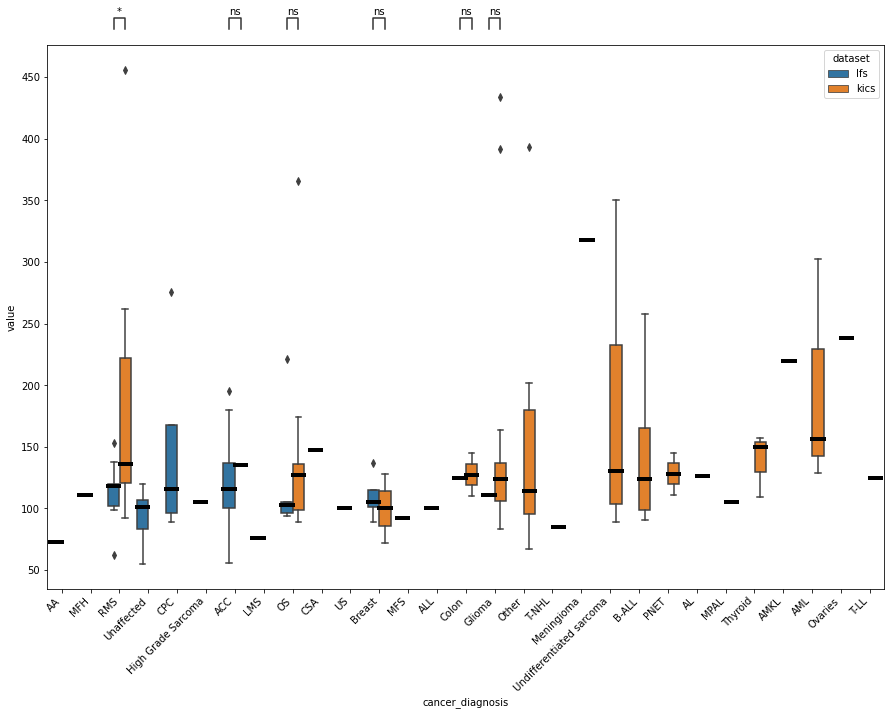

In [30]:
#print(lDel.head(50))

graphSVTissue(kDel, lDel, uniqueDiag, False)


## DUP

['CNS', 'Soft Tissue', 'Blood', 'Bone', 'Other', 'US', 'Thyroid', 'Breast', 'Colon', 'Adrenal', 'Ovaries']
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Colon_lfs vs. Colon_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=1.000e+00
Soft Tissue_lfs vs. Soft Tissue_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:6.846e-04 U_stat=1.800e+01
Adrenal_lfs vs. Adrenal_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:3.250e-01 U_stat=4.000e+00
Blood_lfs vs. Blood_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:3.396e-01 U_stat=4.000e+00
US_lfs vs. US_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:3.130e-01 U_stat=5.000e-01
Breast_lfs vs. Breast_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:6.959e-01 U_stat=3.500e+00
CNS_lfs vs. CNS_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:4.329e-01 U_stat=4.000e+01
Bone_lfs vs. Bone_kics: M

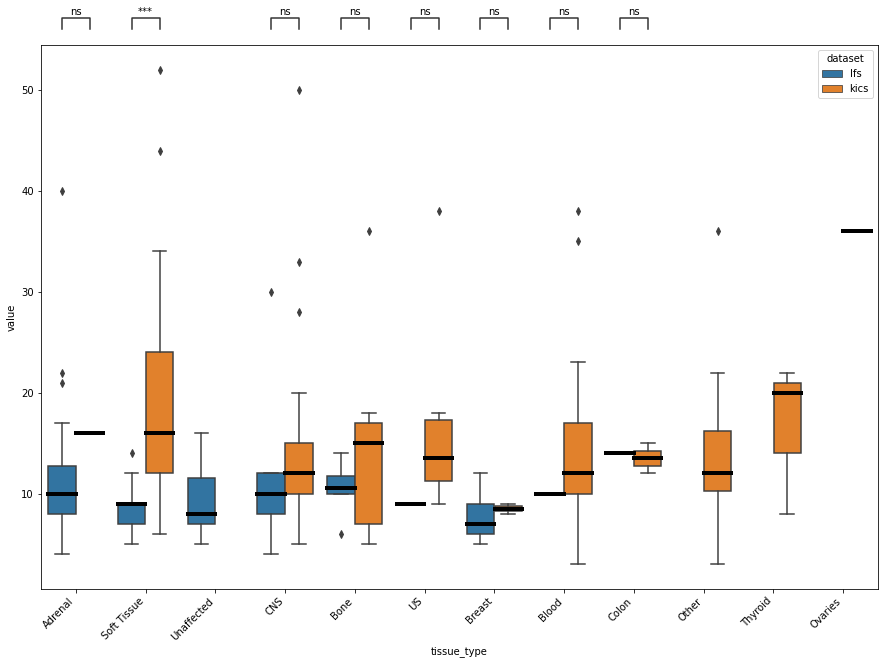

In [31]:
print(kicsTissueList)
graphSVTissue(kDup, lDup, uniqueTissue, True)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Glioma_lfs vs. Glioma_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:7.131e-01 U_stat=1.150e+01
Colon_lfs vs. Colon_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=1.000e+00
Breast_lfs vs. Breast_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:6.959e-01 U_stat=3.500e+00
OS_lfs vs. OS_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:2.851e-01 U_stat=1.400e+01
RMS_lfs vs. RMS_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:4.347e-03 U_stat=1.550e+01
ACC_lfs vs. ACC_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:3.426e-01 U_stat=4.000e+00


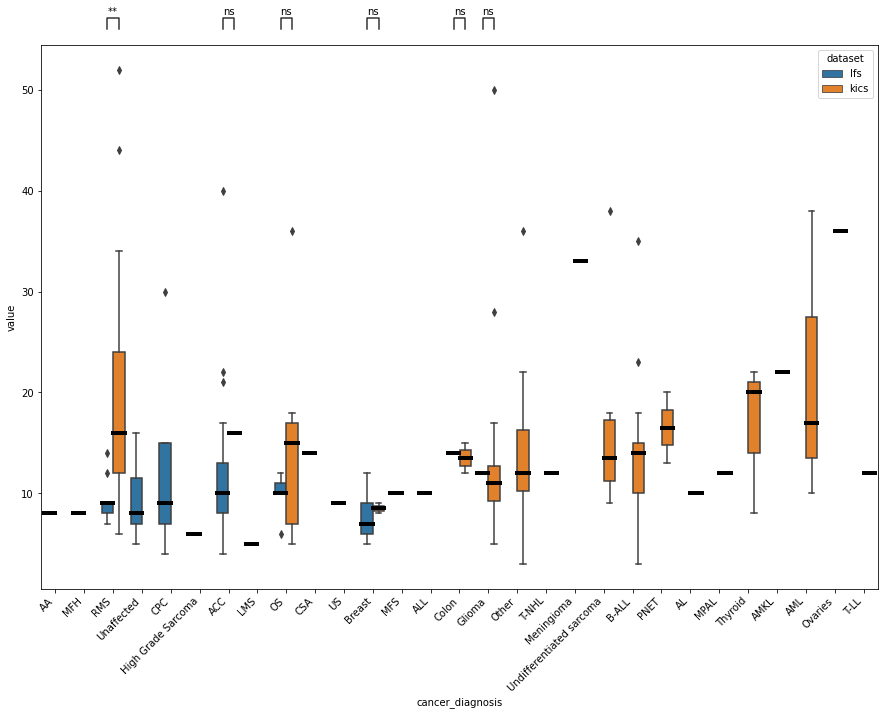

In [32]:
graphSVTissue(kDup, lDup, uniqueDiag, False)


## INV

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Colon_lfs vs. Colon_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=1.000e+00
Soft Tissue_lfs vs. Soft Tissue_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:4.021e-02 U_stat=4.000e+01
Adrenal_lfs vs. Adrenal_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:3.796e-01 U_stat=4.500e+00
Blood_lfs vs. Blood_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:9.368e-01 U_stat=9.500e+00
US_lfs vs. US_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:5.714e-01 U_stat=1.000e+00
Breast_lfs vs. Breast_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=5.000e+00
CNS_lfs vs. CNS_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=5.300e+01
Bone_lfs vs. Bone_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:6.750e-01 U_stat=2.300e+01


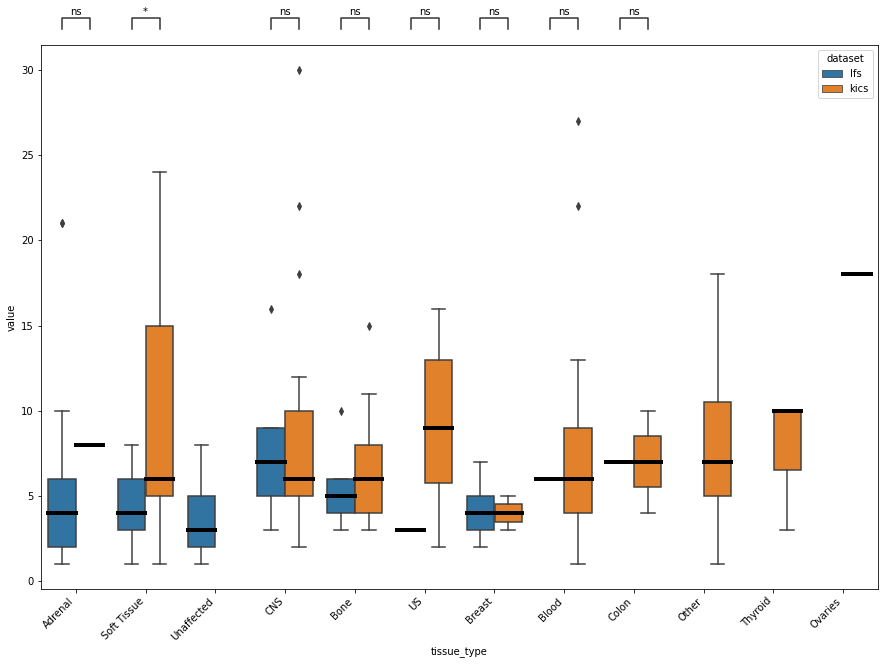

In [33]:
graphSVTissue(kInv, lInv, uniqueTissue, True)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Glioma_lfs vs. Glioma_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:5.795e-01 U_stat=1.250e+01
Colon_lfs vs. Colon_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=1.000e+00
Breast_lfs vs. Breast_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=5.000e+00
OS_lfs vs. OS_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:7.870e-01 U_stat=2.000e+01
RMS_lfs vs. RMS_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:3.794e-02 U_stat=2.300e+01
ACC_lfs vs. ACC_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:4.033e-01 U_stat=4.500e+00


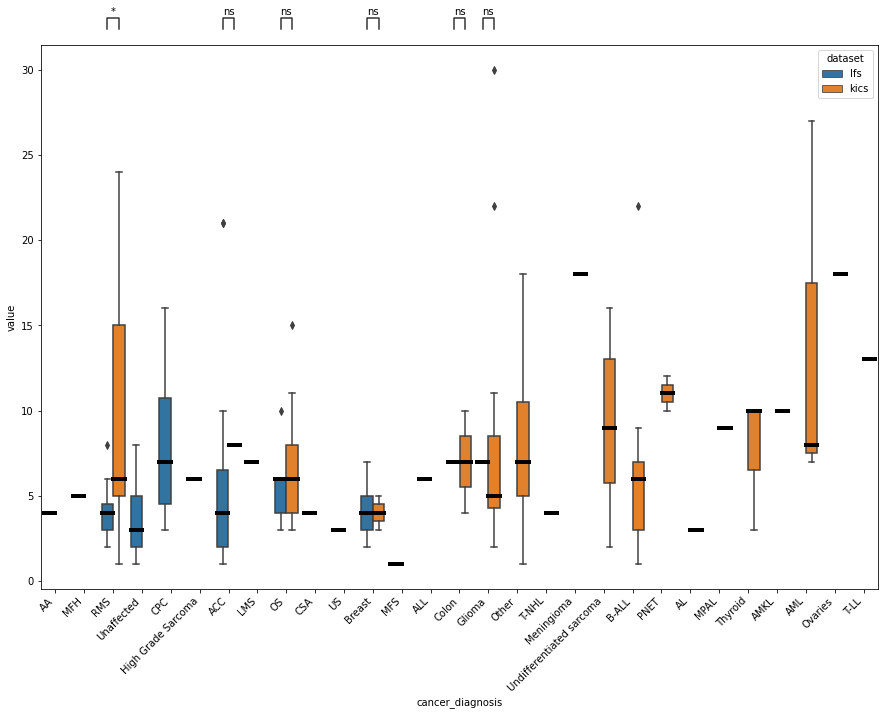

In [34]:
graphSVTissue(kInv, lInv, uniqueDiag, False)


In [35]:
"""
rare variants first >done
LFS vs Kics for Diagnosis type >done 
hypothesis tests >done
LFS vs unaffected >done?
"""



'\nrare variants first >done\nLFS vs Kics for Diagnosis type >done \nhypothesis tests >done\nLFS vs unaffected >done?\n'

In [36]:
def boxplotPoints(title:list, column:list, df: pd.DataFrame , sizeH=20.50, sizeV=17.50, col='red', trans=0.25):
    plt.rcParams["figure.figsize"] = [sizeH, sizeV]
    plt.rcParams["figure.autolayout"] = True
    data = pd.DataFrame({
        t: df[c] for t,c in zip(title, column)})
    
    #print(data)
    plotTest = data
    plotTest = plotTest.stack().to_frame().reset_index().rename(columns={'level_1': 'iden', 0: 'value'}).drop('level_0', axis='columns')
    #print(plotTest.head(50))
    #data.boxplot()
    #BoxGraphMulti(plotTest, 'cat', 'value', 'iden')
    sns.boxplot(data=plotTest, x='iden', y='value')
    
    #plot with boxplot
    sns.stripplot(x = 'iden',
              y = 'value',
                  color = 'red',
                  alpha = 0.25,
              data = plotTest)

    for i, d in enumerate(data):
        print(i)
        y = data[d]
        x = np.random.normal(i, 0.04, len(y))
        plt.scatter(x, y, color = col, alpha = trans)
    
    list1 = df[column[0]].dropna()
    list2 = df[column[1]].dropna()
    print(mannwhitneyu(list1,list2))
    plt.show()

0
1
MannwhitneyuResult(statistic=186.5, pvalue=0.054207574547033184)


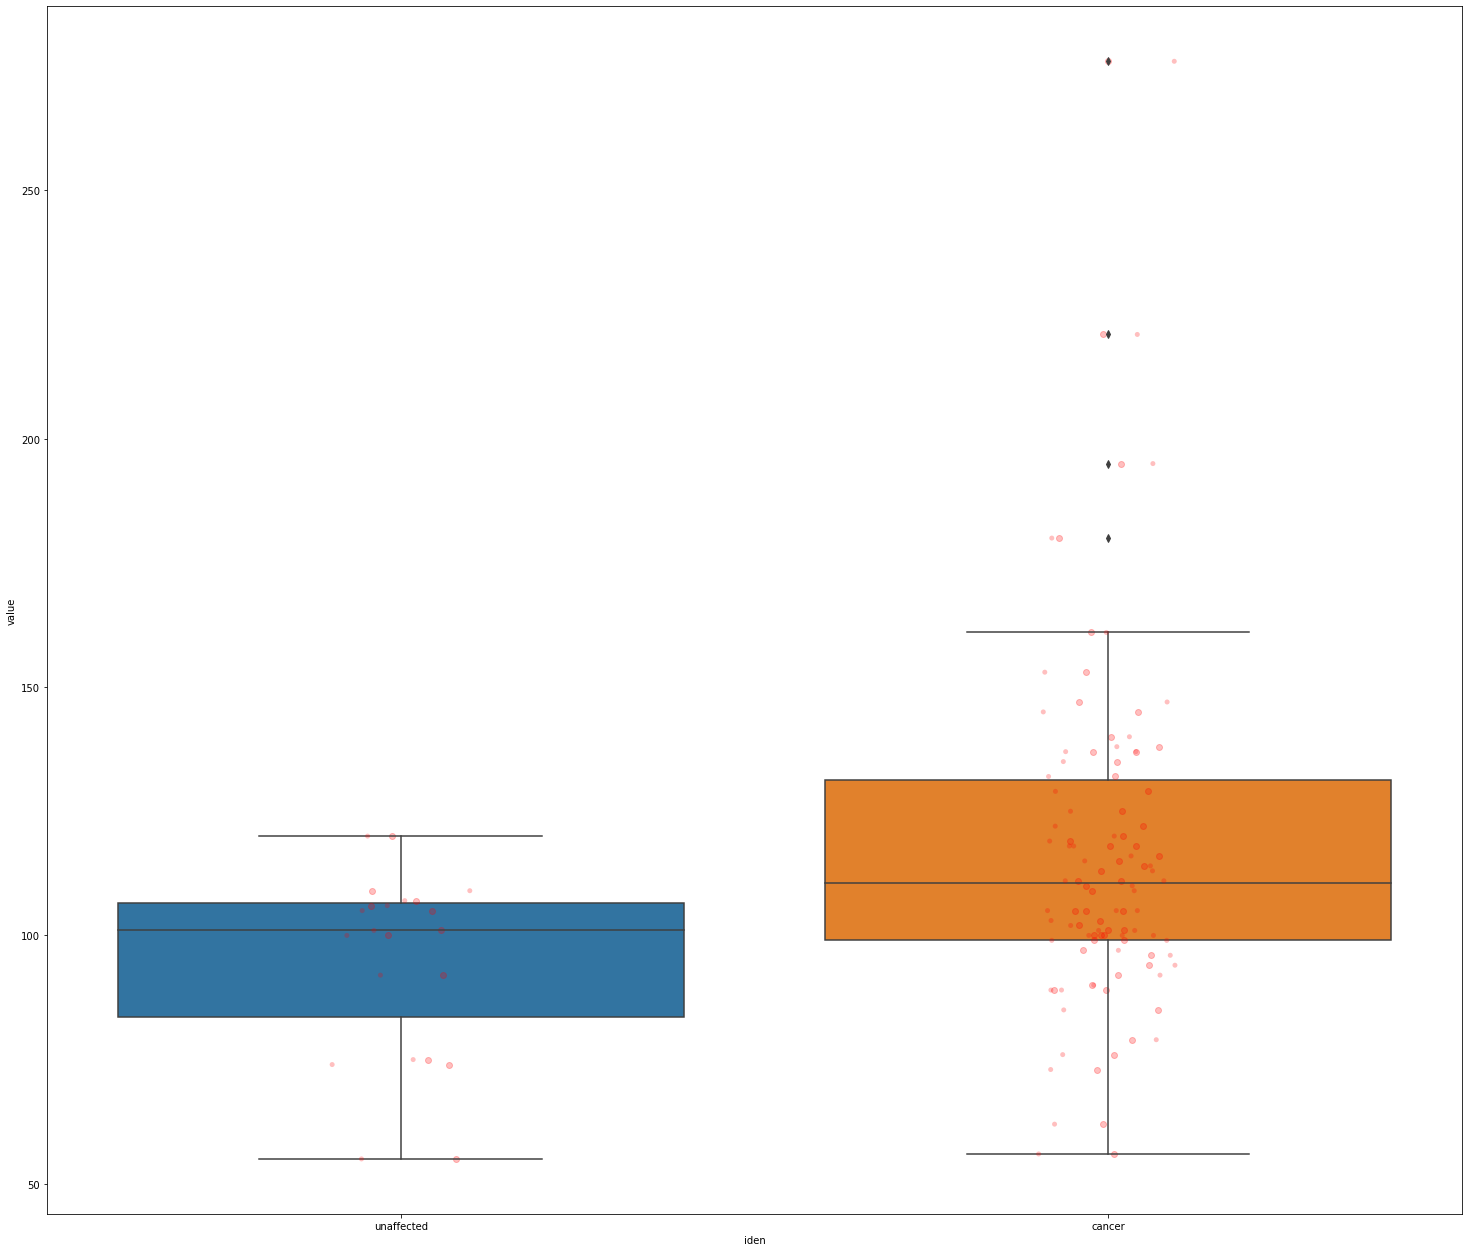

0
1
MannwhitneyuResult(statistic=266.0, pvalue=0.5920316326069894)


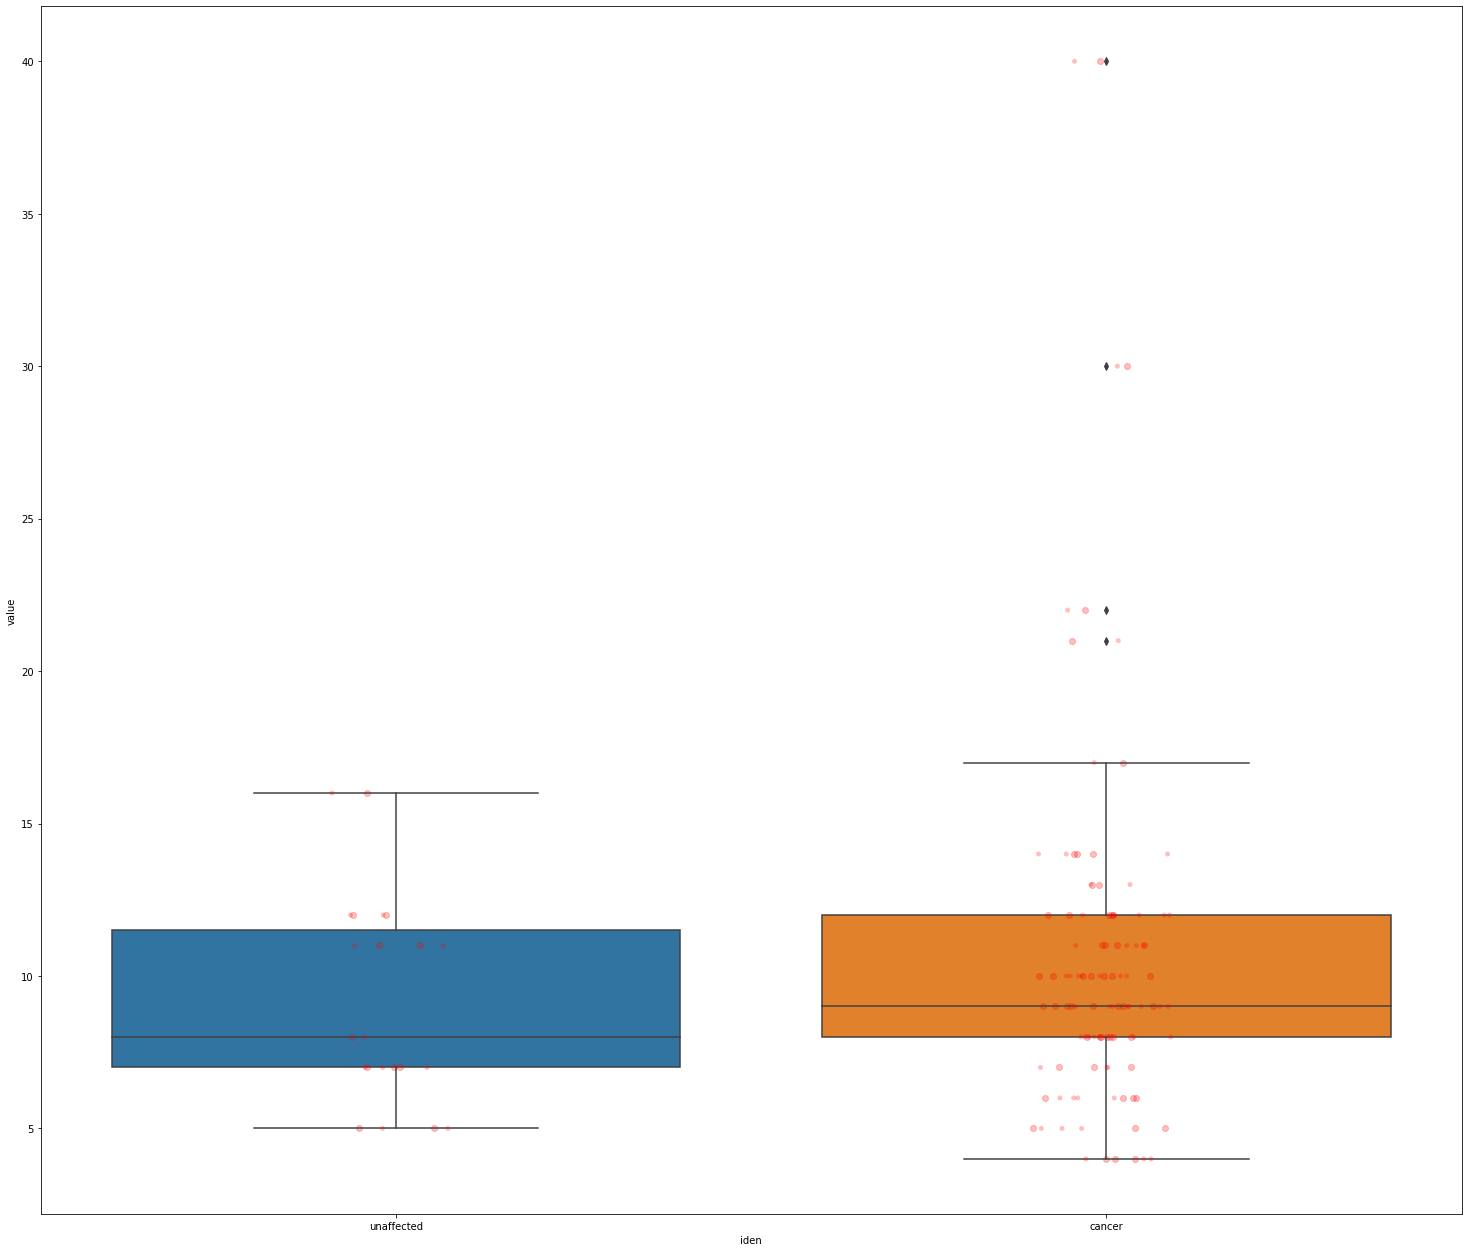

0
1
MannwhitneyuResult(statistic=191.0, pvalue=0.08454067588286607)


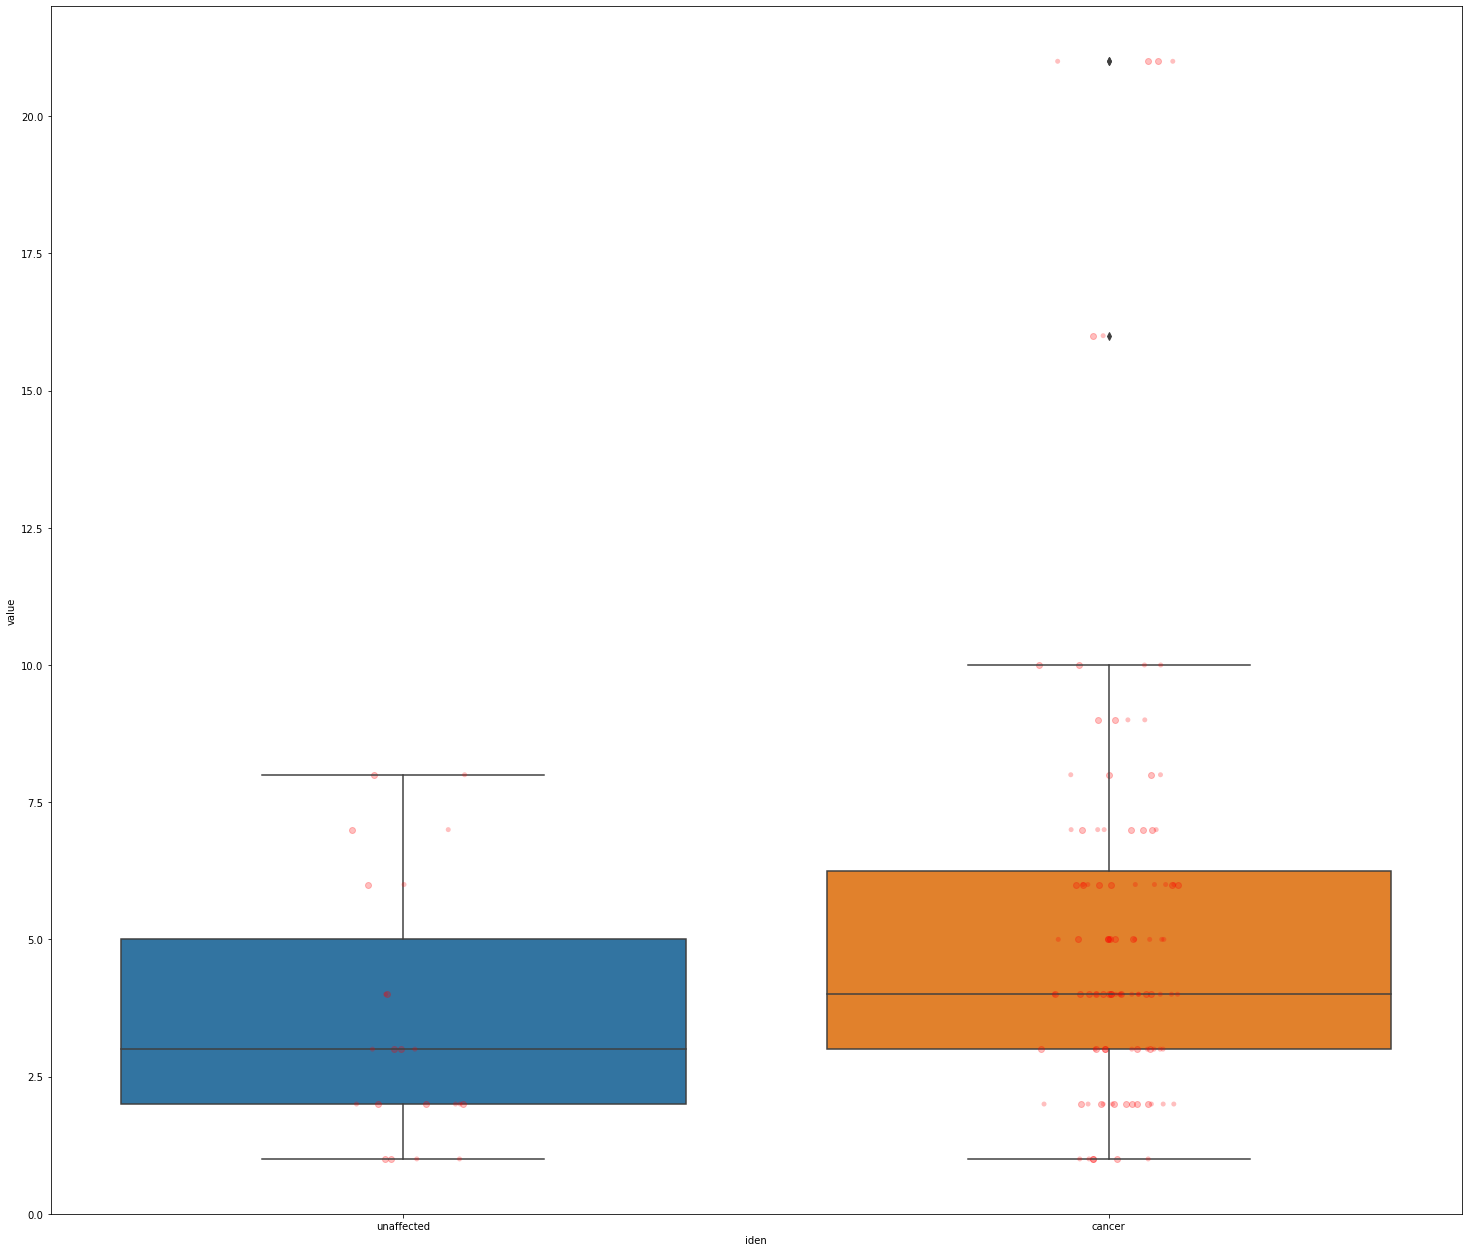

In [37]:
"""
LFS vs Unaffected
"""
#3 big graphs for SV type lfs vs unaffected

#print(bigLDf.head(20))
# print(bigLDf['tissue_type'].unique())
# tempUnaffectedT = bigLDf[bigLDf['tissue_type']=='Unaffected']
# tempUnaffectedD = bigLDf[bigLDf['cancer_diagnosis']=='Unaffected']
# print(tempUnaffectedT['sample_id'].unique())
# print(tempUnaffectedT['cancer_diagnosis'].unique())
# print(tempUnaffectedD['sample_id'].unique())
# print(tempUnaffectedD['cancer_diagnosis'].unique())

#both the tissue_type and cancer_diagnosis have the same unaffected

unaffectedDf = bigLDf[bigLDf['tissue_type']=='Unaffected'].drop(['GD_AF', 'sample', 'tissue_type',
                                                                 'cancer_diagnosis', 'SV chrom','ageofonset'], axis=1)
cancerDf = bigLDf[bigLDf['tissue_type']!='Unaffected'].drop(['GD_AF', 'sample', 'tissue_type',
                                                             'cancer_diagnosis', 'SV chrom','ageofonset'], axis=1)

uDel = unaffectedDf[unaffectedDf['SV type'] == 'DEL'].value_counts().to_frame().reset_index()
cDel = cancerDf[cancerDf['SV type'] == 'DEL'].value_counts().to_frame().reset_index()

mergedDel = pd.DataFrame(data = {'unaffected':uDel[0],'cancer':cDel[0]})

uDup = unaffectedDf[unaffectedDf['SV type'] == 'DUP'].value_counts().to_frame().reset_index()
cDup = cancerDf[cancerDf['SV type'] == 'DUP'].value_counts().to_frame().reset_index()
mergedDup = pd.DataFrame(data = {'unaffected':uDup[0],'cancer':cDup[0]})

uInv = unaffectedDf[unaffectedDf['SV type'] == 'INV'].value_counts().to_frame().reset_index()
cInv = cancerDf[cancerDf['SV type'] == 'INV'].value_counts().to_frame().reset_index()
mergedInv = pd.DataFrame(data = {'unaffected':uInv[0],'cancer':cInv[0]})

#print(mergedInv)
title = ['unaffected','cancer']

boxplotPoints(title, title, mergedDel)
boxplotPoints(title, title, mergedDup)
boxplotPoints(title, title, mergedInv)


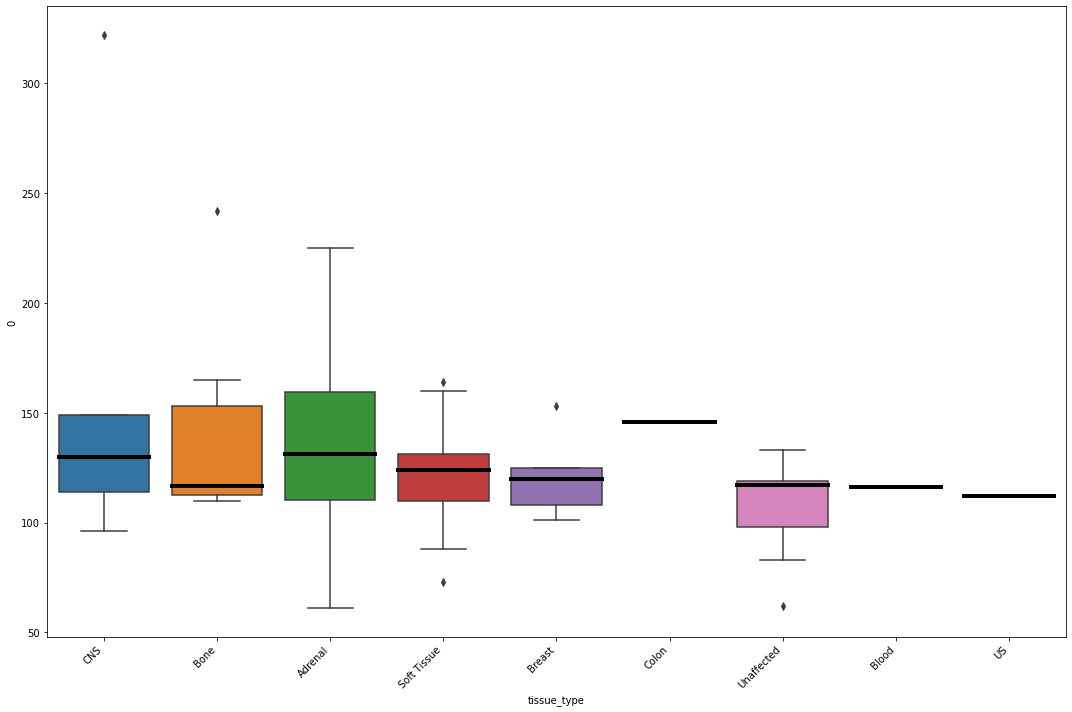

In [38]:
"""
Between Cancer Types
Make an LFS graph, a KiCS Graph
- SV Specific
- Overall <Done
"""

def graphBoxGen(xColumnName, df, ycol = 0):
    plt.rcParams["figure.figsize"] = [15, 10]
    ax = sns.boxplot(data=df, x=xColumnName, y=ycol, medianprops={"linewidth": 4, 'color':'black'})
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha="right")

    #add statistical test here

#     # initializing list
#     uniqueTissue = list(df[xColumnName].unique()) 

#     #does all possible pairings given a list
#     listPairing = [(a,b) for x, a in enumerate(uniqueTissue) for b in uniqueTissue[x+1:]]
#     #print(listPairing)

#     annot = Annotator(ax, listPairing, data=df, x=xColumnName, y=ycol)
#     annot.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose=2)
#     annot.apply_and_annotate()
    

#overall LFS
ldf = bigLDf.drop(['GD_AF','sample','ageofonset'], axis=1)
kdf = bigKDf.drop(['CCP germline','abbv_id','tumour_class','ageofonset'],axis=1)

#print(ldf)
ldfGenTissue = ldf.drop(['SV chrom', 'SV type', 'cancer_diagnosis'],axis=1)
ldfGenTissue = ldfGenTissue.value_counts().to_frame().reset_index()

graphBoxGen('tissue_type', ldfGenTissue)


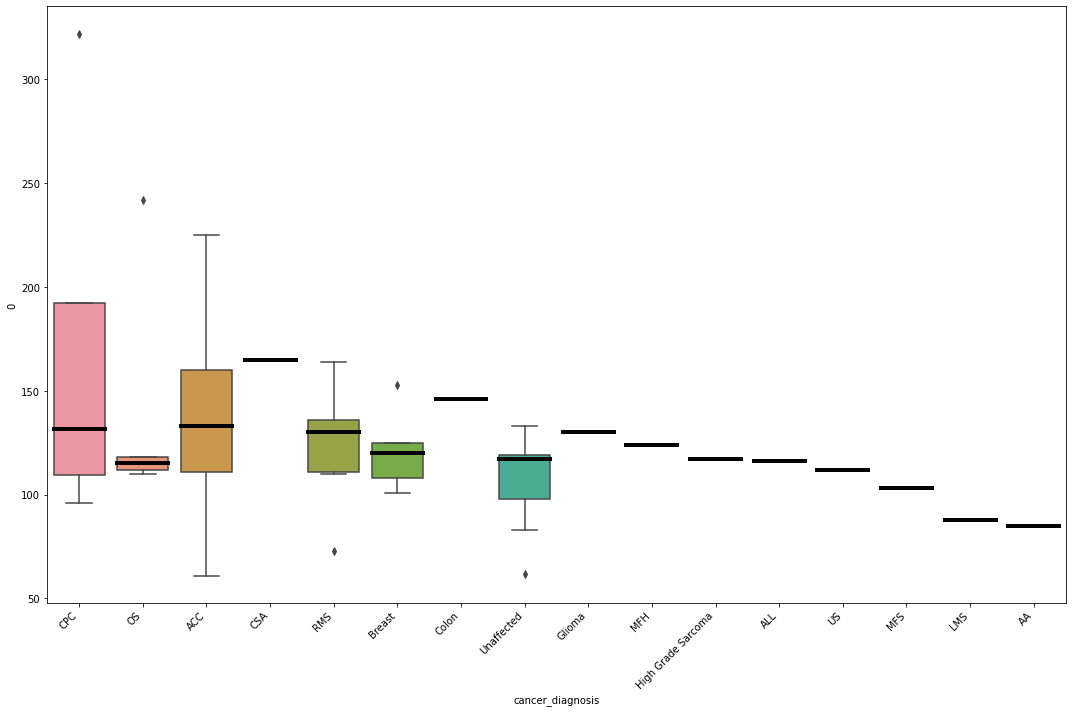

In [39]:
ldfGenDiag = ldf.drop(['SV chrom', 'SV type', 'tissue_type'],axis=1)
ldfGenDiag = ldfGenDiag.value_counts().to_frame().reset_index()

graphBoxGen('cancer_diagnosis', ldfGenDiag)

      sample_id  tissue_type    0
0        284386  Soft Tissue  532
1        286909          CNS  484
2        300683          CNS  472
3        316626        Other  447
4        271112         Bone  417
..          ...          ...  ...
88       297445          CNS  101
89       299338          CNS  100
90       305577        Other   93
91  N_-_18_2697       Breast   85
92       299321        Other   73

[93 rows x 3 columns]


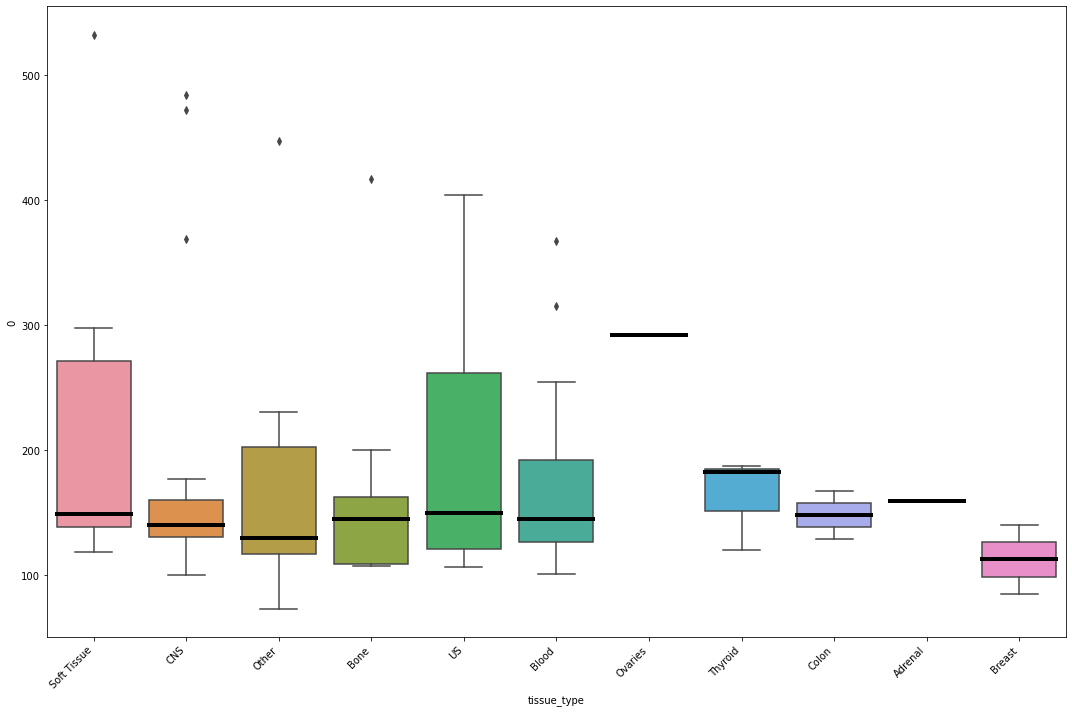

In [40]:
"""
Overall Kics
""" 
kdfGenTissue = kdf.drop(['SV type', 'cancer_diagnosis'], axis=1)
kdfGenTissue = kdfGenTissue.value_counts().to_frame().reset_index()
print(kdfGenTissue)
graphBoxGen('tissue_type', kdfGenTissue)

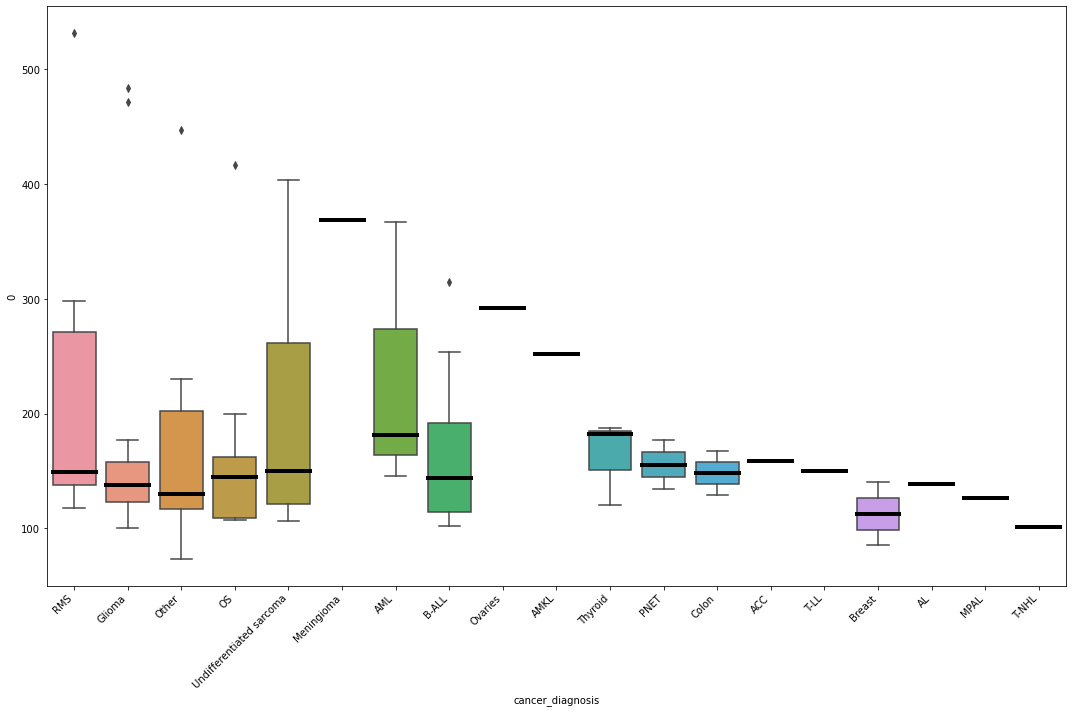

In [41]:
#overall cancer diagnosis
kdfGenDiag = kdf.drop(['SV type', 'tissue_type'], axis=1)
kdfGenDiag = kdfGenDiag.value_counts().to_frame().reset_index()
graphBoxGen('cancer_diagnosis', kdfGenDiag)

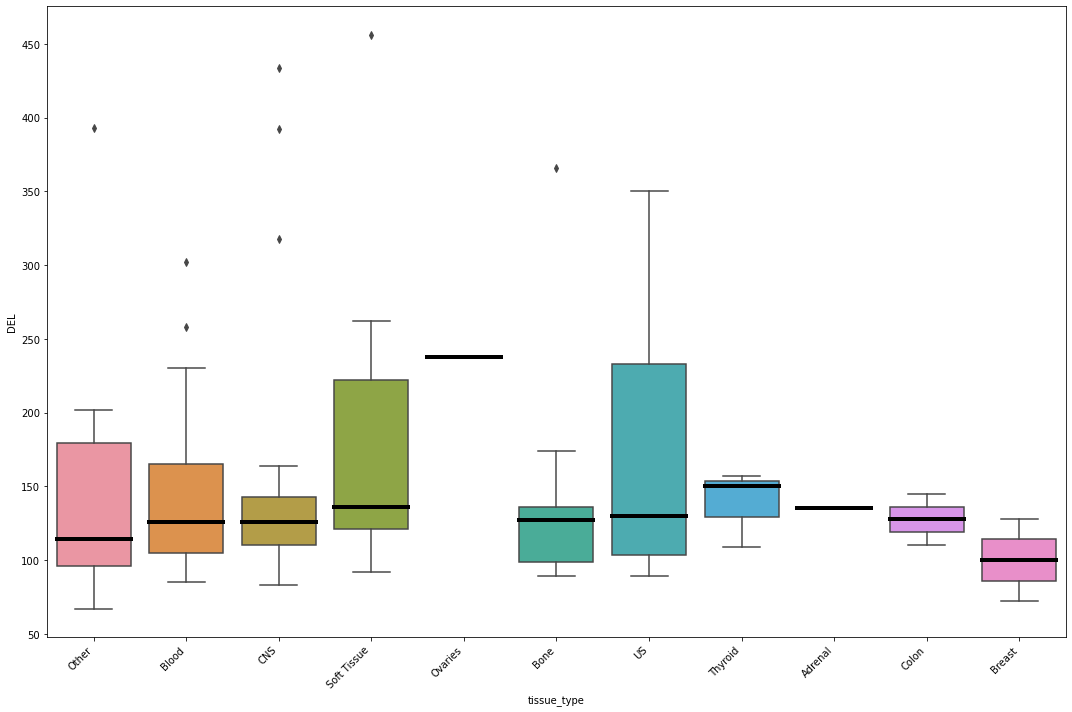

In [42]:
"""
SV Specific
"""
#Overall tissue ones
kT = kdf.drop(['cancer_diagnosis'], axis=1).groupby(['sample_id', 'SV type','tissue_type']).size()
kT = kT.unstack(1)

lT = ldf.drop(['cancer_diagnosis'], axis=1).groupby(['sample_id', 'SV type', 'tissue_type']).size()
lT = lT.unstack(1)

graphBoxGen('tissue_type', kT.drop(['DUP', 'INV'], axis=1).reset_index(),'DEL')

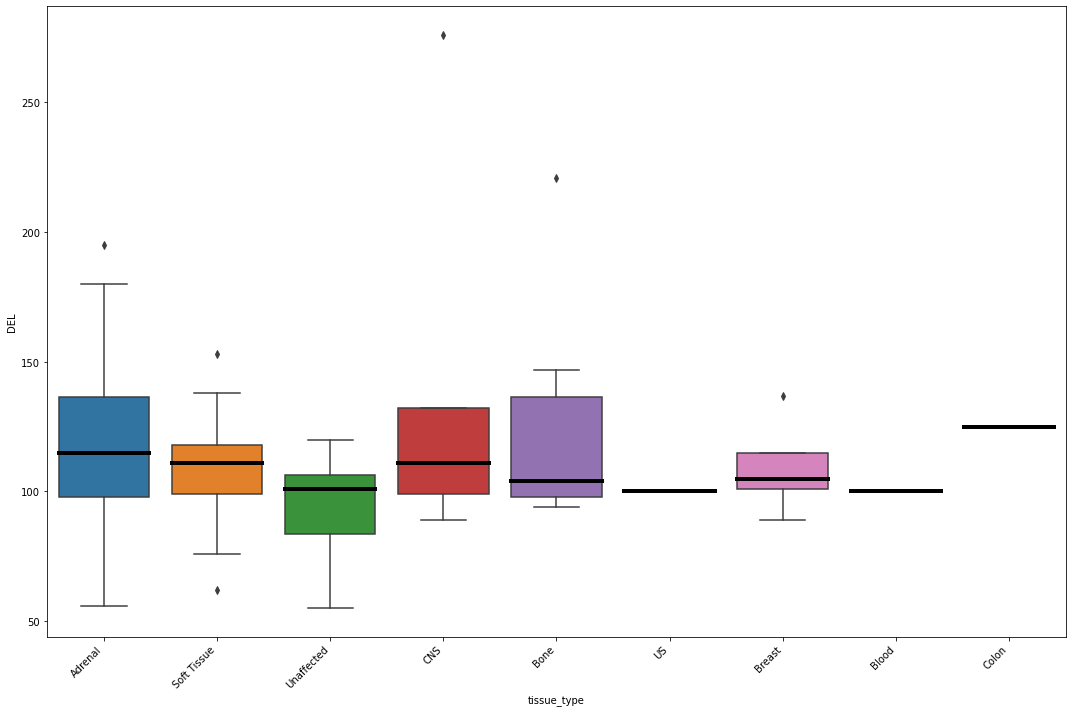

In [43]:
graphBoxGen('tissue_type', lT.drop(['DUP', 'INV'], axis=1).reset_index(),'DEL')


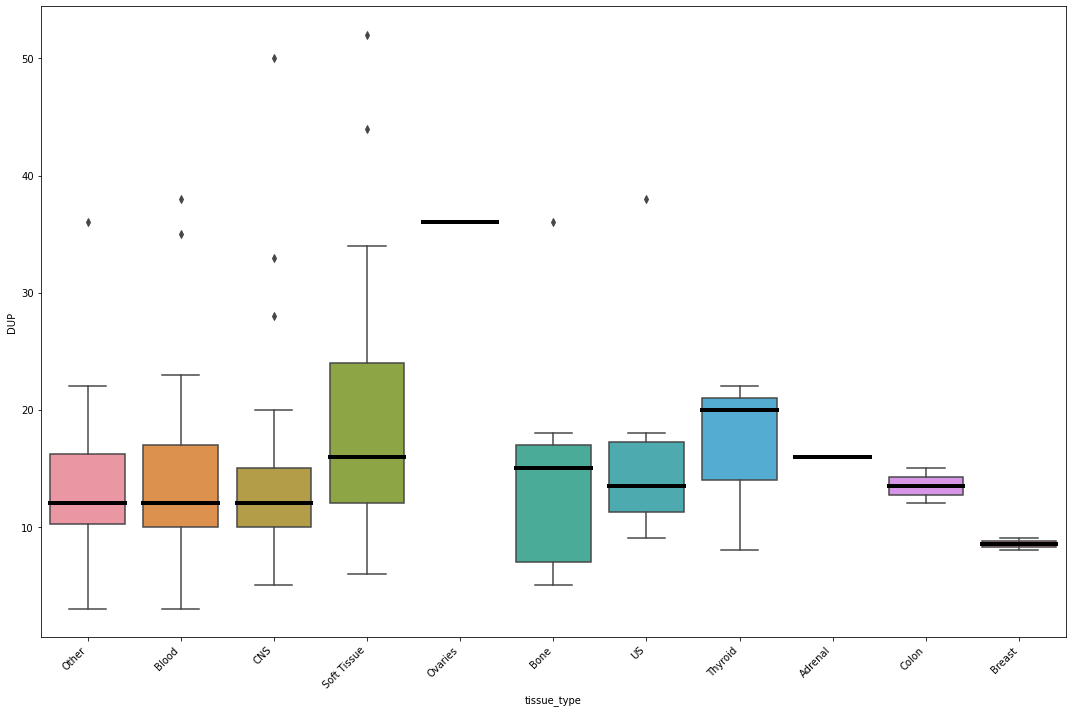

In [44]:
graphBoxGen('tissue_type', kT.drop(['DEL', 'INV'], axis=1).reset_index(),'DUP')

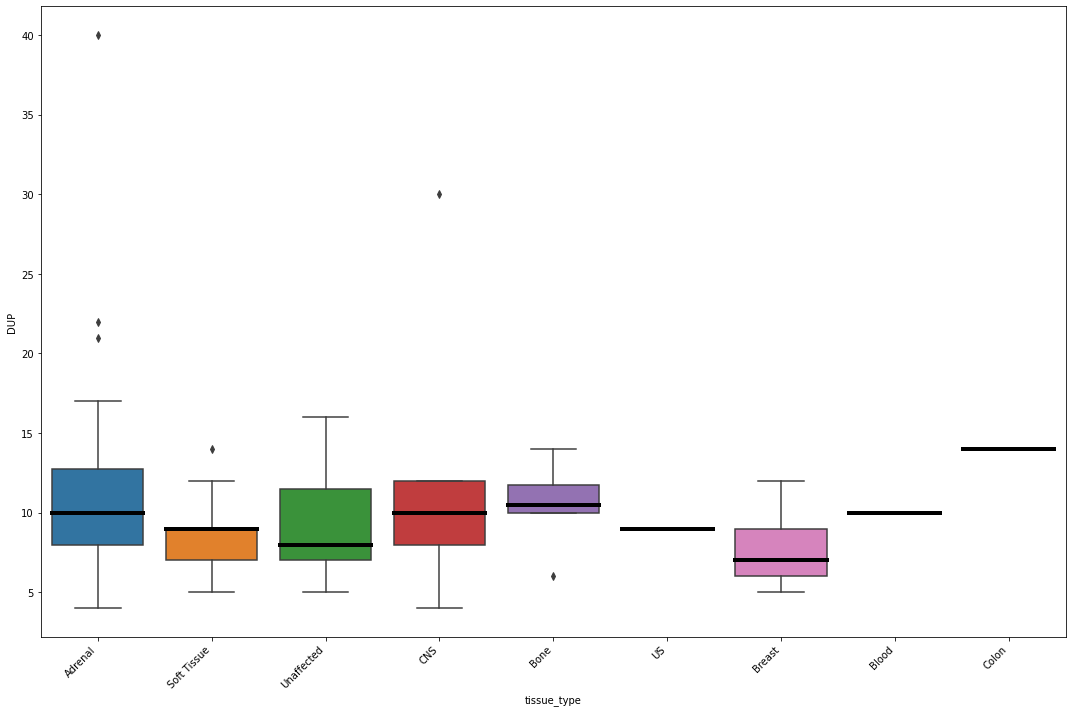

In [45]:
graphBoxGen('tissue_type', lT.drop(['DEL', 'INV'], axis=1).reset_index(),'DUP')

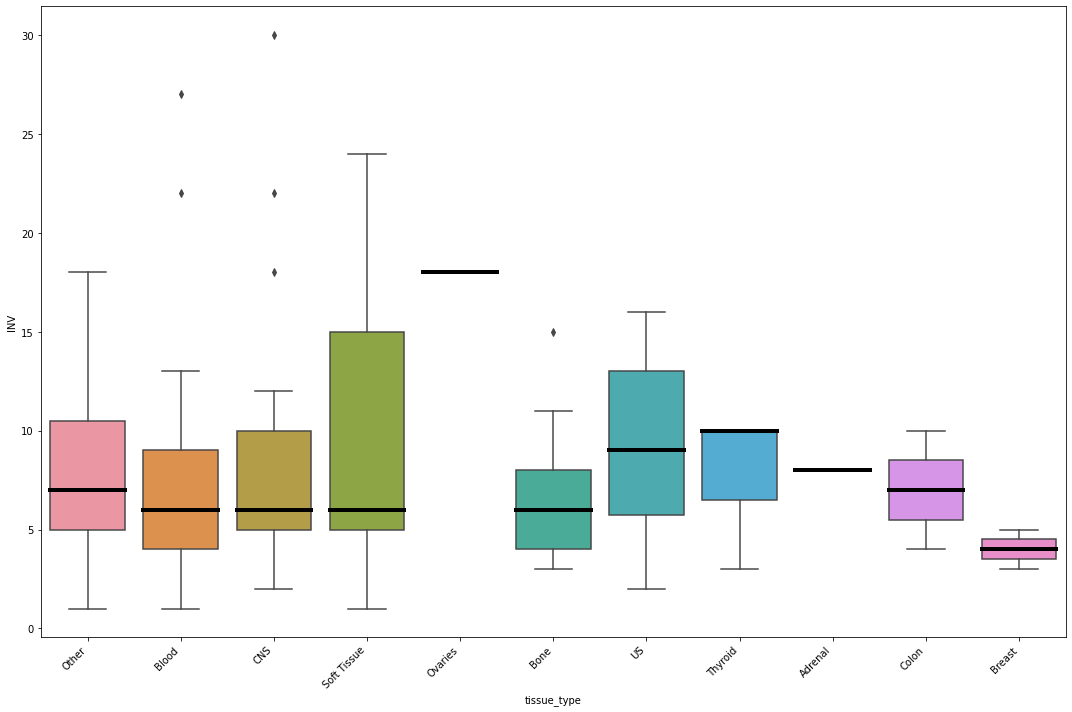

In [46]:
graphBoxGen('tissue_type', kT.drop(['DUP', 'DEL'], axis=1).reset_index(),'INV')

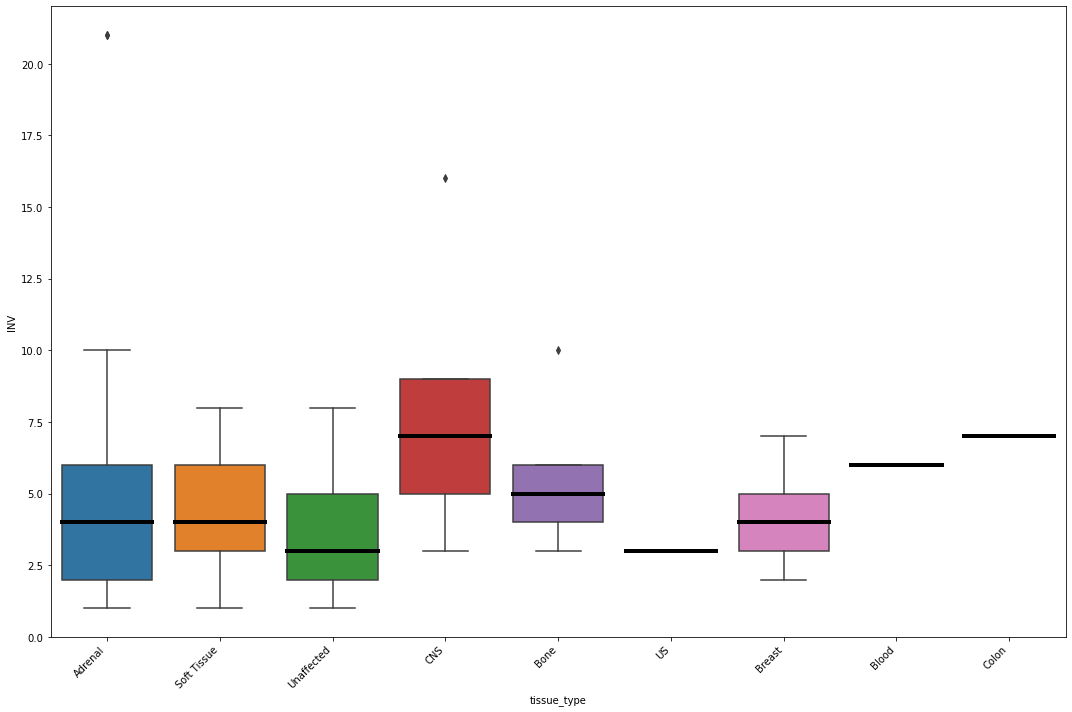

In [47]:
graphBoxGen('tissue_type', lT.drop(['DUP', 'DEL'], axis=1).reset_index(),'INV')

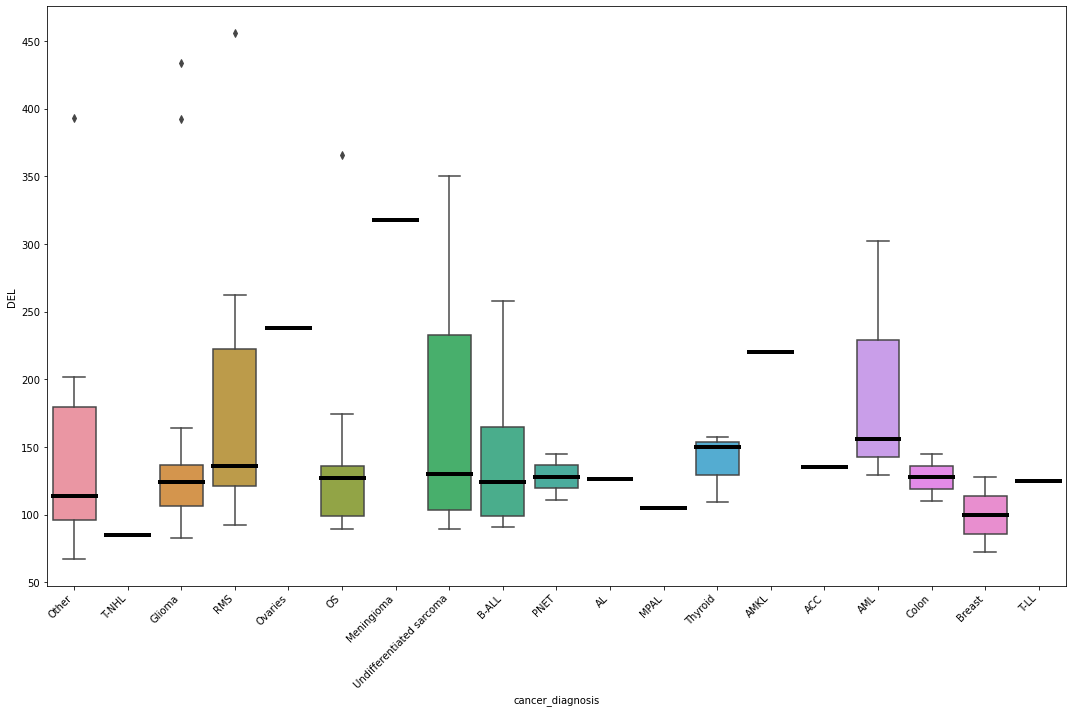

In [48]:
#diganosis, SV Specific
kD = kdf.drop(['tissue_type'], axis=1).groupby(['sample_id', 'SV type','cancer_diagnosis']).size()
kD = kD.unstack(1)

lD = ldf.drop(['tissue_type'], axis=1).groupby(['sample_id', 'SV type','cancer_diagnosis']).size()
lD = lD.unstack(1)

graphBoxGen('cancer_diagnosis', kD.drop(['DUP', 'INV'], axis=1).reset_index(),'DEL')

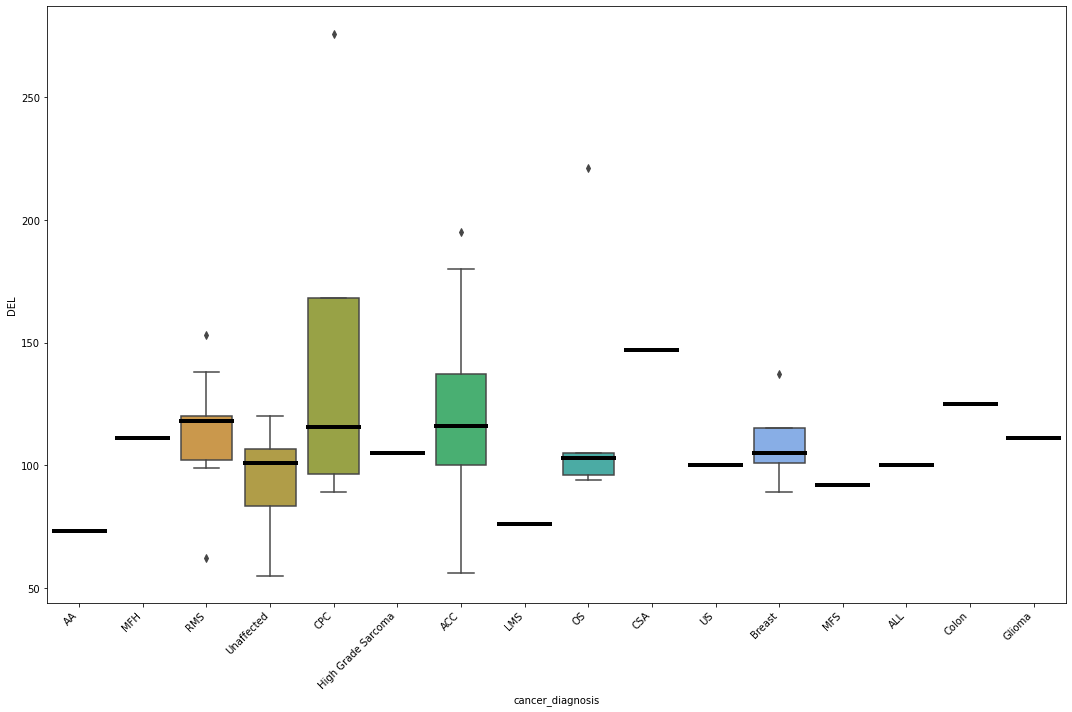

In [49]:
graphBoxGen('cancer_diagnosis', lD.drop(['DUP', 'INV'], axis=1).reset_index(),'DEL')

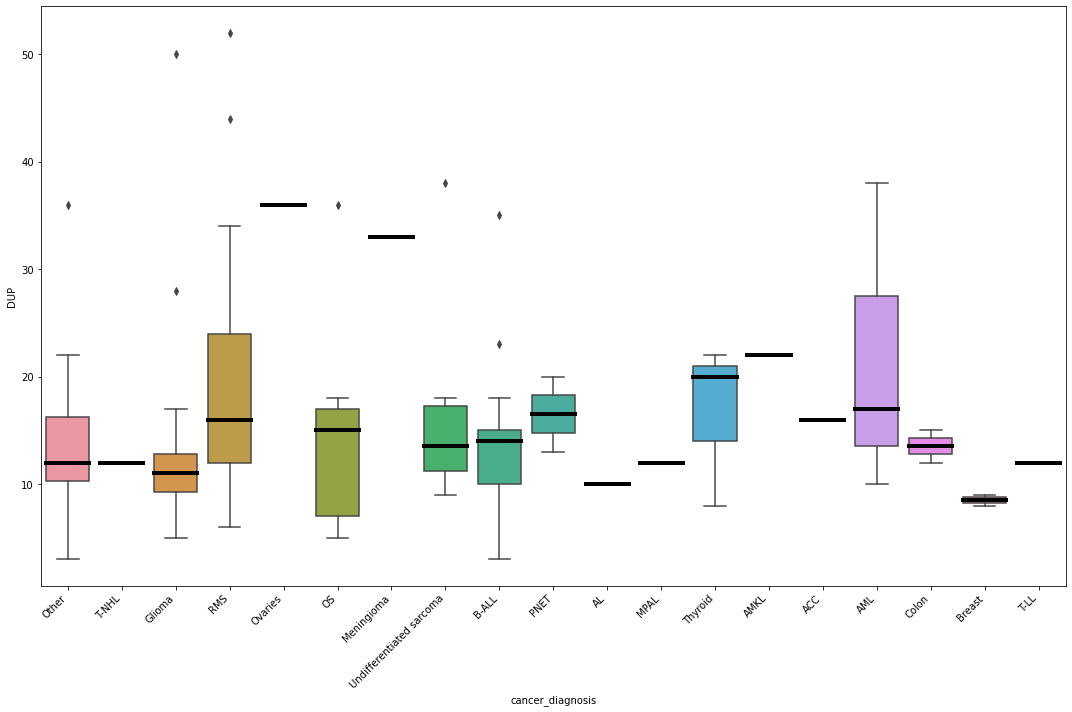

In [50]:
graphBoxGen('cancer_diagnosis', kD.drop(['DEL', 'INV'], axis=1).reset_index(),'DUP')

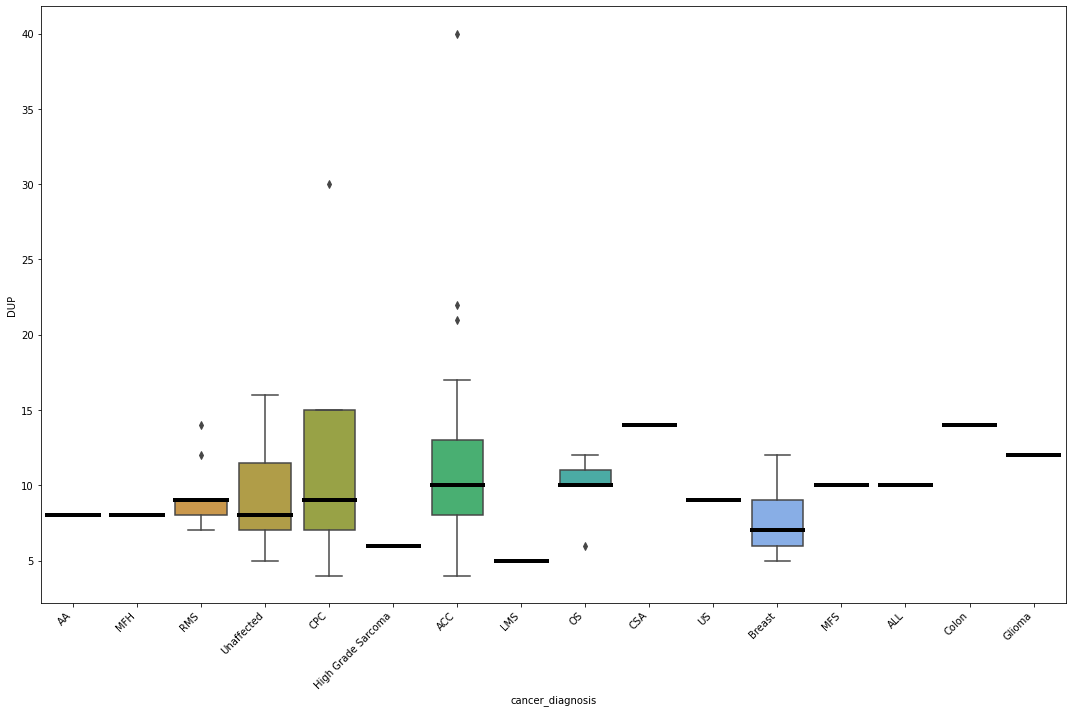

In [51]:
graphBoxGen('cancer_diagnosis', lD.drop(['DEL', 'INV'], axis=1).reset_index(),'DUP')

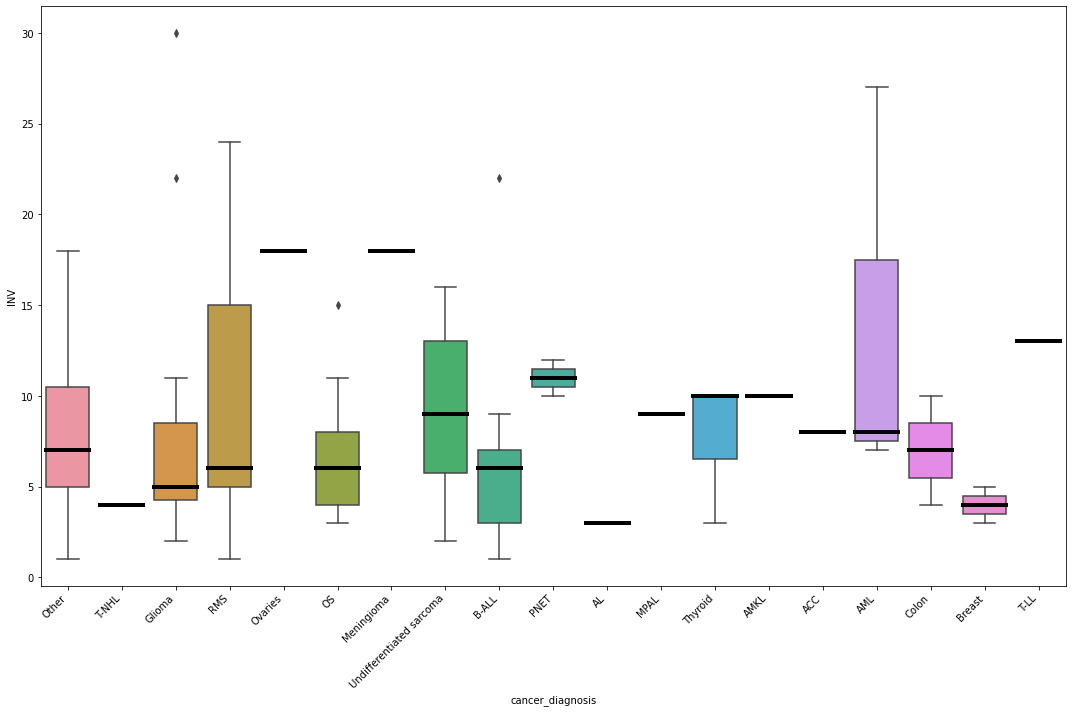

In [52]:
graphBoxGen('cancer_diagnosis', kD.drop(['DUP', 'DEL'], axis=1).reset_index(),'INV')

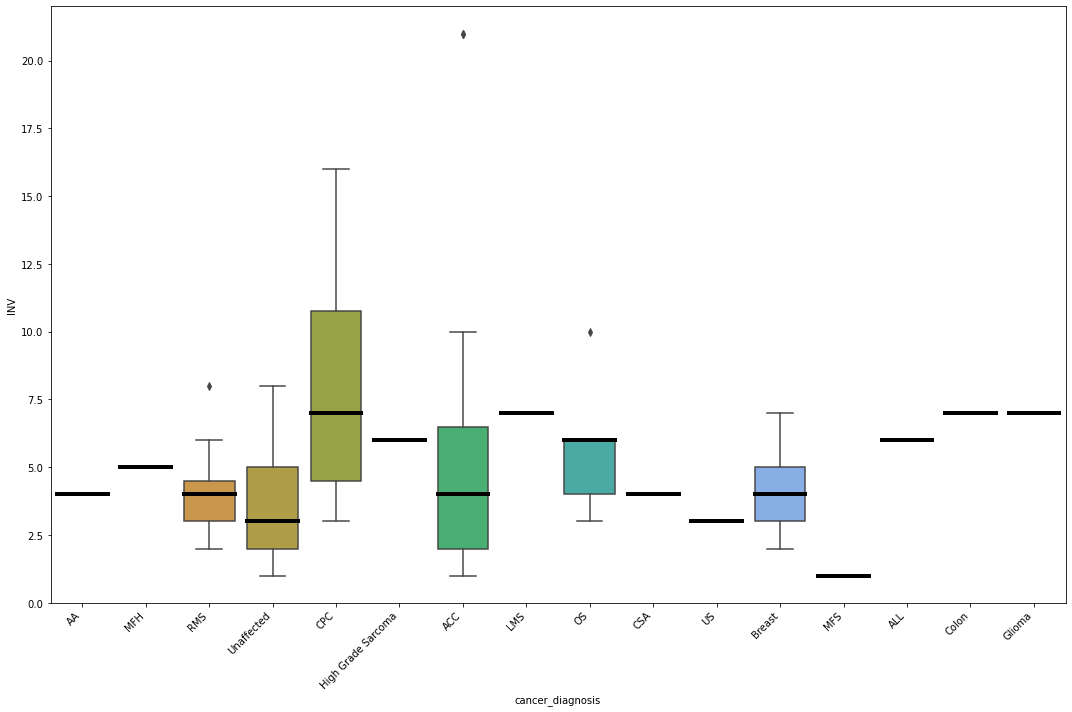

In [53]:
graphBoxGen('cancer_diagnosis', lD.drop(['DUP', 'DEL'], axis=1).reset_index(),'INV')

In [54]:
"""
LFS vs Unaffected -> done
Types of graphs:
age of onset (kics vs lfs) >SV Specific but not cancer specific
Between cancer types in kics and in lfs >done

Same for TE
"""

'\nLFS vs Unaffected -> done\nTypes of graphs:\nage of onset (kics vs lfs) >SV Specific but not cancer specific\nBetween cancer types in kics and in lfs >done\n\nSame for TE\n'

In [88]:
"SV Specific for different age of onsets"
#remove unaffected from lfs
#using diagnosis_age (days) and ageofonset || kics and lfs

lfsCancer = bigLDf[bigLDf['tissue_type']!='Unaffected'].drop(['GD_AF', 'sample', 'tissue_type',
                                                             'SV chrom', 'cancer_diagnosis'],axis=1)
lfsUnaffected = bigLDf[bigLDf['tissue_type']=='Unaffected'].drop(['GD_AF', 'sample', 'tissue_type',
                                                             'SV chrom', 'cancer_diagnosis'],axis=1)
kicsCancer = bigKDf.drop(['abbv_id', 'CCP germline', 'tumour_class','tissue_type','cancer_diagnosis'],axis=1)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

<6_lfs vs. <6_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:1.124e-01 U_stat=4.410e+02
>=6_lfs vs. >=6_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:1.203e-02 U_stat=4.240e+02


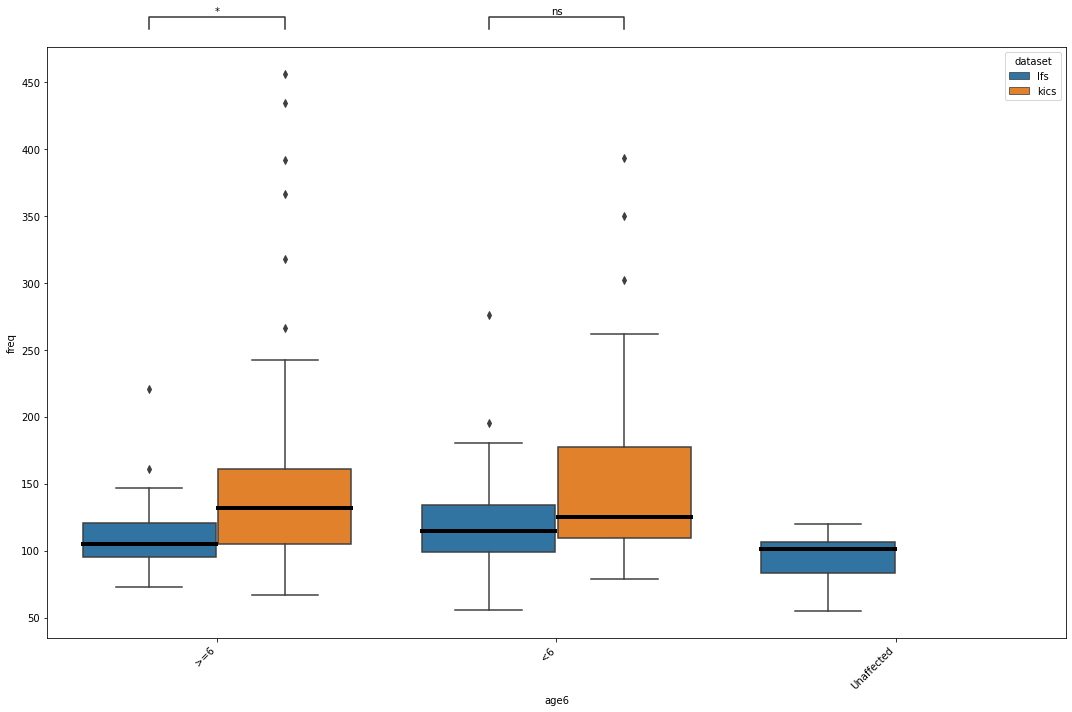

In [109]:
def ageOfOnsetKics(row):
    if row['ageofonset']<2190:
        return '<6'
    if row['ageofonset']>=2190:
        return '>=6'
    
def ageOfOnsetLfs(row):
    if row['ageofonset']<72:
        return '<6'
    if row['ageofonset']>=72:
        return '>=6'    

kicsCancer['ageofonset']=kicsCancer['ageofonset'].astype('float')
#print(lfsCancer.apply(lambda row: ageOfOnsetLfs(row), axis=1).value_counts())
#print(kicsCancer.apply(lambda row: ageOfOnsetKics(row), axis=1).value_counts())

lfsCancer['age6'] = lfsCancer.apply(lambda row: ageOfOnsetLfs(row), axis=1)
kicsCancer['age6'] = kicsCancer.apply(lambda row: ageOfOnsetKics(row), axis=1)
lfsUnaffected['age6'] = 'Unaffected'

LCDel = lfsCancer.loc[lfsCancer['SV type'] == 'DEL']
LUDel = lfsUnaffected.loc[lfsUnaffected['SV type'] == 'DEL']
KCDel = kicsCancer.loc[kicsCancer['SV type'] == 'DEL']

LCDup = lfsCancer.loc[lfsCancer['SV type'] == 'DUP']
LUDup = lfsUnaffected.loc[lfsUnaffected['SV type'] == 'DUP']
KCDup = kicsCancer.loc[kicsCancer['SV type'] == 'DUP']

LCInv = lfsCancer.loc[lfsCancer['SV type'] == 'INV']
LUInv = lfsUnaffected.loc[lfsUnaffected['SV type'] == 'INV']
KCInv = kicsCancer.loc[kicsCancer['SV type'] == 'INV']

#graph them now (2190 is 365*6)

#print(LCInv.columns)

def cleaning(df):
    df = df.drop(['SV type','ageofonset'],axis=1)
    df = df.groupby(['sample_id']).value_counts()
    df = df.to_frame().reset_index()
    df.rename(columns = {0: 'freq'},inplace = True)
    return df

def mergeDFs(lfs1, lfs2, kics1):
    lfs1 = cleaning(lfs1)
    lfs2 = cleaning(lfs2)
    kics1 = cleaning(kics1)
    lfsMerged = pd.concat([lfs1,lfs2])
    lfsMerged['dataset'] = 'lfs'
    kics1['dataset'] = 'kics'
    mergedDf = pd.concat([lfsMerged, kics1])
    
    BoxGraphMulti(mergedDf, 'age6', 'freq', 'dataset', ['<6','>=6','Unaffected'])

mergeDFs(LCDel, LUDel, KCDel)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

<6_lfs vs. <6_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:4.725e-02 U_stat=4.095e+02
>=6_lfs vs. >=6_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:1.754e-05 U_stat=2.580e+02


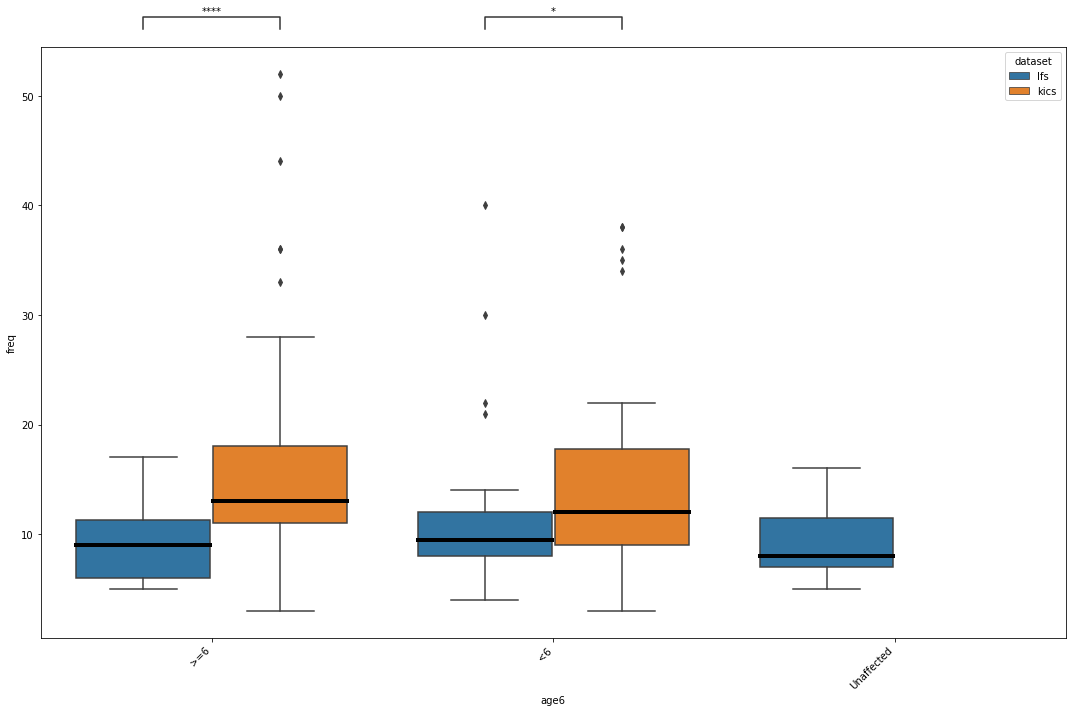

In [110]:
mergeDFs(LCDup, LUDup, KCDup)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

<6_lfs vs. <6_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:4.551e-02 U_stat=3.780e+02
>=6_lfs vs. >=6_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:9.243e-03 U_stat=4.165e+02


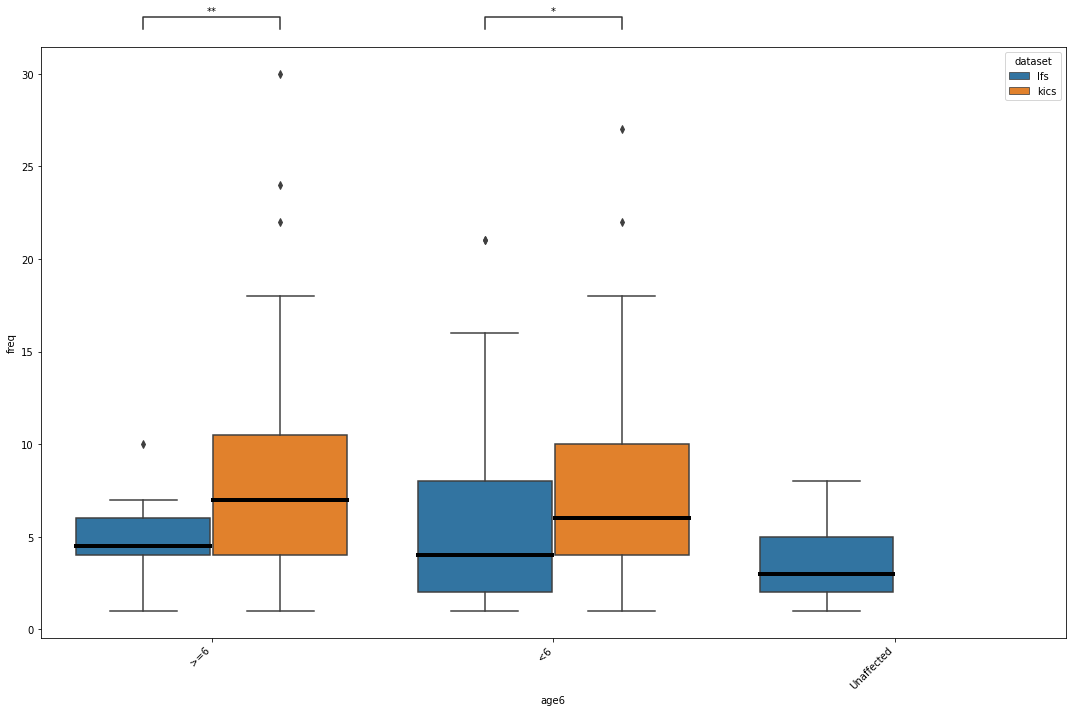

In [111]:
mergeDFs(LCInv, LUInv, KCInv)